# Importing packages

In [ ]:
# Install the contractions package - https://github.com/kootenpv/contractions
# !pip install contractions seaborn textblob scikit-learn-intelex optuna catboost

In [2]:
# !pip install transformers datasets evaluate

In [1]:
import os
import pandas as pd
import numpy as np
from scipy.sparse import hstack
from typing import Union, List
from time import gmtime, strftime

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
%matplotlib inline
plt.style.use('ggplot')

# text preprocessing
import nltk
import re
import contractions
import string
from textblob import TextBlob # spelling correction

from sklearnex import patch_sklearn 
patch_sklearn()

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier

# Model performance evaluation
import evaluate
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
    confusion_matrix,
    classification_report,
)

# Hugging Face Dataset
from datasets import Dataset

# for tuning hyperparameters
import optuna

from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import Trainer, TrainingArguments, get_scheduler

# Modeling
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import LinearLR
from torch.nn.init import xavier_uniform_
from torch.utils.data import DataLoader

# Other useful
import math
import collections
import gc
from torch.types import Device
from prompt_toolkit import output

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# for reproducibility
import random
seed_value=42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Loading data and deleting rows with missing data

In [3]:
df = pd.read_csv(filepath_or_buffer='SubjFakeRealDataset.csv', index_col=0)
df.shape

(50847, 2)

In [4]:
# we'll save it just in case
missed_texts = df[df.text.isnull()]
df = df.dropna()
df.shape

(50847, 2)

# Exploratory data analysis

## Exploring the data distributions

In [5]:
unique_labels = sorted(df.label.unique())
print(unique_labels)

['entertainment_fake', 'entertainment_real', 'health_fake', 'health_real', 'politics_fake', 'politics_real', 'sports_fake', 'sports_real']


In [6]:
labels_subdf = {}
for lbl in unique_labels:
    labels_subdf[lbl] = df[df['label']==lbl]
    print(f'{lbl}: {labels_subdf[lbl].shape}')

entertainment_fake: (5755, 2)
entertainment_real: (5754, 2)
health_fake: (5670, 2)
health_real: (5670, 2)
politics_fake: (7000, 2)
politics_real: (7000, 2)
sports_fake: (6999, 2)
sports_real: (6999, 2)


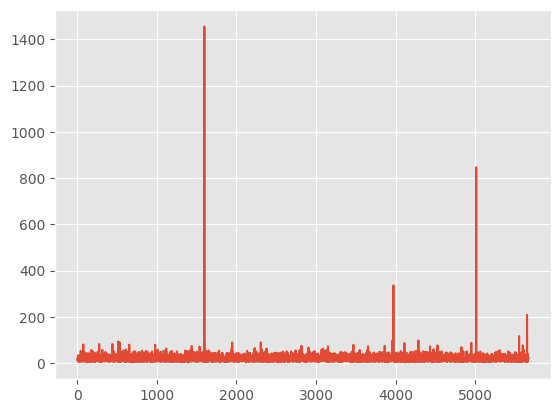

In [7]:
plt.plot([len(txt.split()) for txt in labels_subdf['health_fake'].text])
# plt.plot([len(txt.split()) for txt in fake.text])

Let's explore quantiles. First we will create a new column with text lengths.

In [8]:
df['text_length'] = [len(txt.split()) for txt in df.text]
df.head(3)

,text,label,text_length
0,Our daily update is published. We’ve now track...,health_real,30
1,???Joe Biden and the Democrats want to prosecu...,health_fake,19
2,Anne Hathaway and Kate Hudson Interview – BRID...,entertainment_fake,9


Then we will print the quantiles:

In [9]:
print(df['text_length'].quantile([0.01, 0.05, 0.10, 0.5, 0.9, 0.95, 0.99]))

0.01     3.0
0.05     7.0
0.10     8.0
0.50    14.0
0.90    37.0
0.95    44.0
0.99    65.0
Name: text_length, dtype: float64


Finally we clip the dataframe by values of the text lengths between 5-th and 99-th quantiles.

In [10]:
df = df[df['text_length'] >= df['text_length'].quantile(0.05)]
df = df[df['text_length'] <= df['text_length'].quantile(0.99)]
df = df.reset_index(drop=True)
print(f'New shape after clipping: {df.shape}')

New shape after clipping: (47949, 3)


Let's check the text lengths by labels after clipping:

In [11]:
labels_subdf_clipped = {}
for lbl in unique_labels:
    labels_subdf_clipped[lbl] = df[df['label']==lbl]
    print(f'{lbl}: {labels_subdf_clipped[lbl].shape}')

entertainment_fake: (5105, 3)
entertainment_real: (5203, 3)
health_fake: (5432, 3)
health_real: (5658, 3)
politics_fake: (6945, 3)
politics_real: (6887, 3)
sports_fake: (5931, 3)
sports_real: (6788, 3)


In [12]:
def print_quantiles(data_real: Union[pd.Series, List], data_fake: Union[pd.Series, List], name: str) -> None:
    print(f'Length quantiles of the "{name}" category:')
    print('\treal\tfake')
    print(f'0.01 | {np.quantile([len(txt.split()) for txt in data_real], 0.01)} | {np.quantile([len(txt.split()) for txt in data_fake], 0.01)}')
    print(f'0.05 | {np.quantile([len(txt.split()) for txt in data_real], 0.05)} | {np.quantile([len(txt.split()) for txt in data_fake], 0.05)}')
    print(f'0.10 | {np.quantile([len(txt.split()) for txt in data_real], 0.10)} | {np.quantile([len(txt.split()) for txt in data_fake], 0.10)}')
    print(f'0.50 | {np.quantile([len(txt.split()) for txt in data_real], 0.50)} | {np.quantile([len(txt.split()) for txt in data_fake], 0.50)}')
    print(f'0.90 | {np.quantile([len(txt.split()) for txt in data_real], 0.90)} | {np.quantile([len(txt.split()) for txt in data_fake], 0.90)}')
    print(f'0.95 | {np.quantile([len(txt.split()) for txt in data_real], 0.95)} | {np.quantile([len(txt.split()) for txt in data_fake], 0.95)}')
    print(f'0.99 | {np.quantile([len(txt.split()) for txt in data_real], 0.99)} | {np.quantile([len(txt.split()) for txt in data_fake], 0.99)}')
    print()
    print(f'Max and min length of the "{name}" category:')
    print('\treal\tfake')
    print(f'max | {max([len(txt.split()) for txt in data_real])} | {max([len(txt.split()) for txt in data_fake])}')
    print(f'min | {min([len(txt.split()) for txt in data_real])} | {min([len(txt.split()) for txt in data_fake])}')
    

In [13]:
for category in ['entertainment', 'health', 'politics', 'sports']:
    print_quantiles(df[df['label']==f'{category}_real'].text, df[df['label']==f'{category}_fake'].text, category)

Length quantiles of the "entertainment" category:
	real	fake
0.01 | 7.0 | 7.0
0.05 | 7.0 | 7.0
0.10 | 8.0 | 8.0
0.50 | 11.0 | 12.0
0.90 | 16.0 | 16.0
0.95 | 17.0 | 18.0
0.99 | 21.0 | 21.960000000000036

Max and min length of the "entertainment" category:
	real	fake
max | 53 | 38
min | 7 | 7
Length quantiles of the "health" category:
	real	fake
0.01 | 9.0 | 7.0
0.05 | 13.0 | 8.0
0.10 | 16.0 | 9.0
0.50 | 32.0 | 16.0
0.90 | 45.0 | 35.0
0.95 | 48.0 | 41.0
0.99 | 52.0 | 51.0

Max and min length of the "health" category:
	real	fake
max | 59 | 65
min | 7 | 7
Length quantiles of the "politics" category:
	real	fake
0.01 | 7.0 | 8.0
0.05 | 7.0 | 9.0
0.10 | 8.0 | 10.0
0.50 | 10.0 | 14.0
0.90 | 13.0 | 20.0
0.95 | 14.0 | 23.0
0.99 | 16.0 | 29.0

Max and min length of the "politics" category:
	real	fake
max | 23 | 38
min | 7 | 7
Length quantiles of the "sports" category:
	real	fake
0.01 | 7.0 | 7.0
0.05 | 9.0 | 8.0
0.10 | 10.0 | 9.0
0.50 | 24.0 | 22.0
0.90 | 39.0 | 50.0
0.95 | 44.0 | 57.0
0.99 | 56.

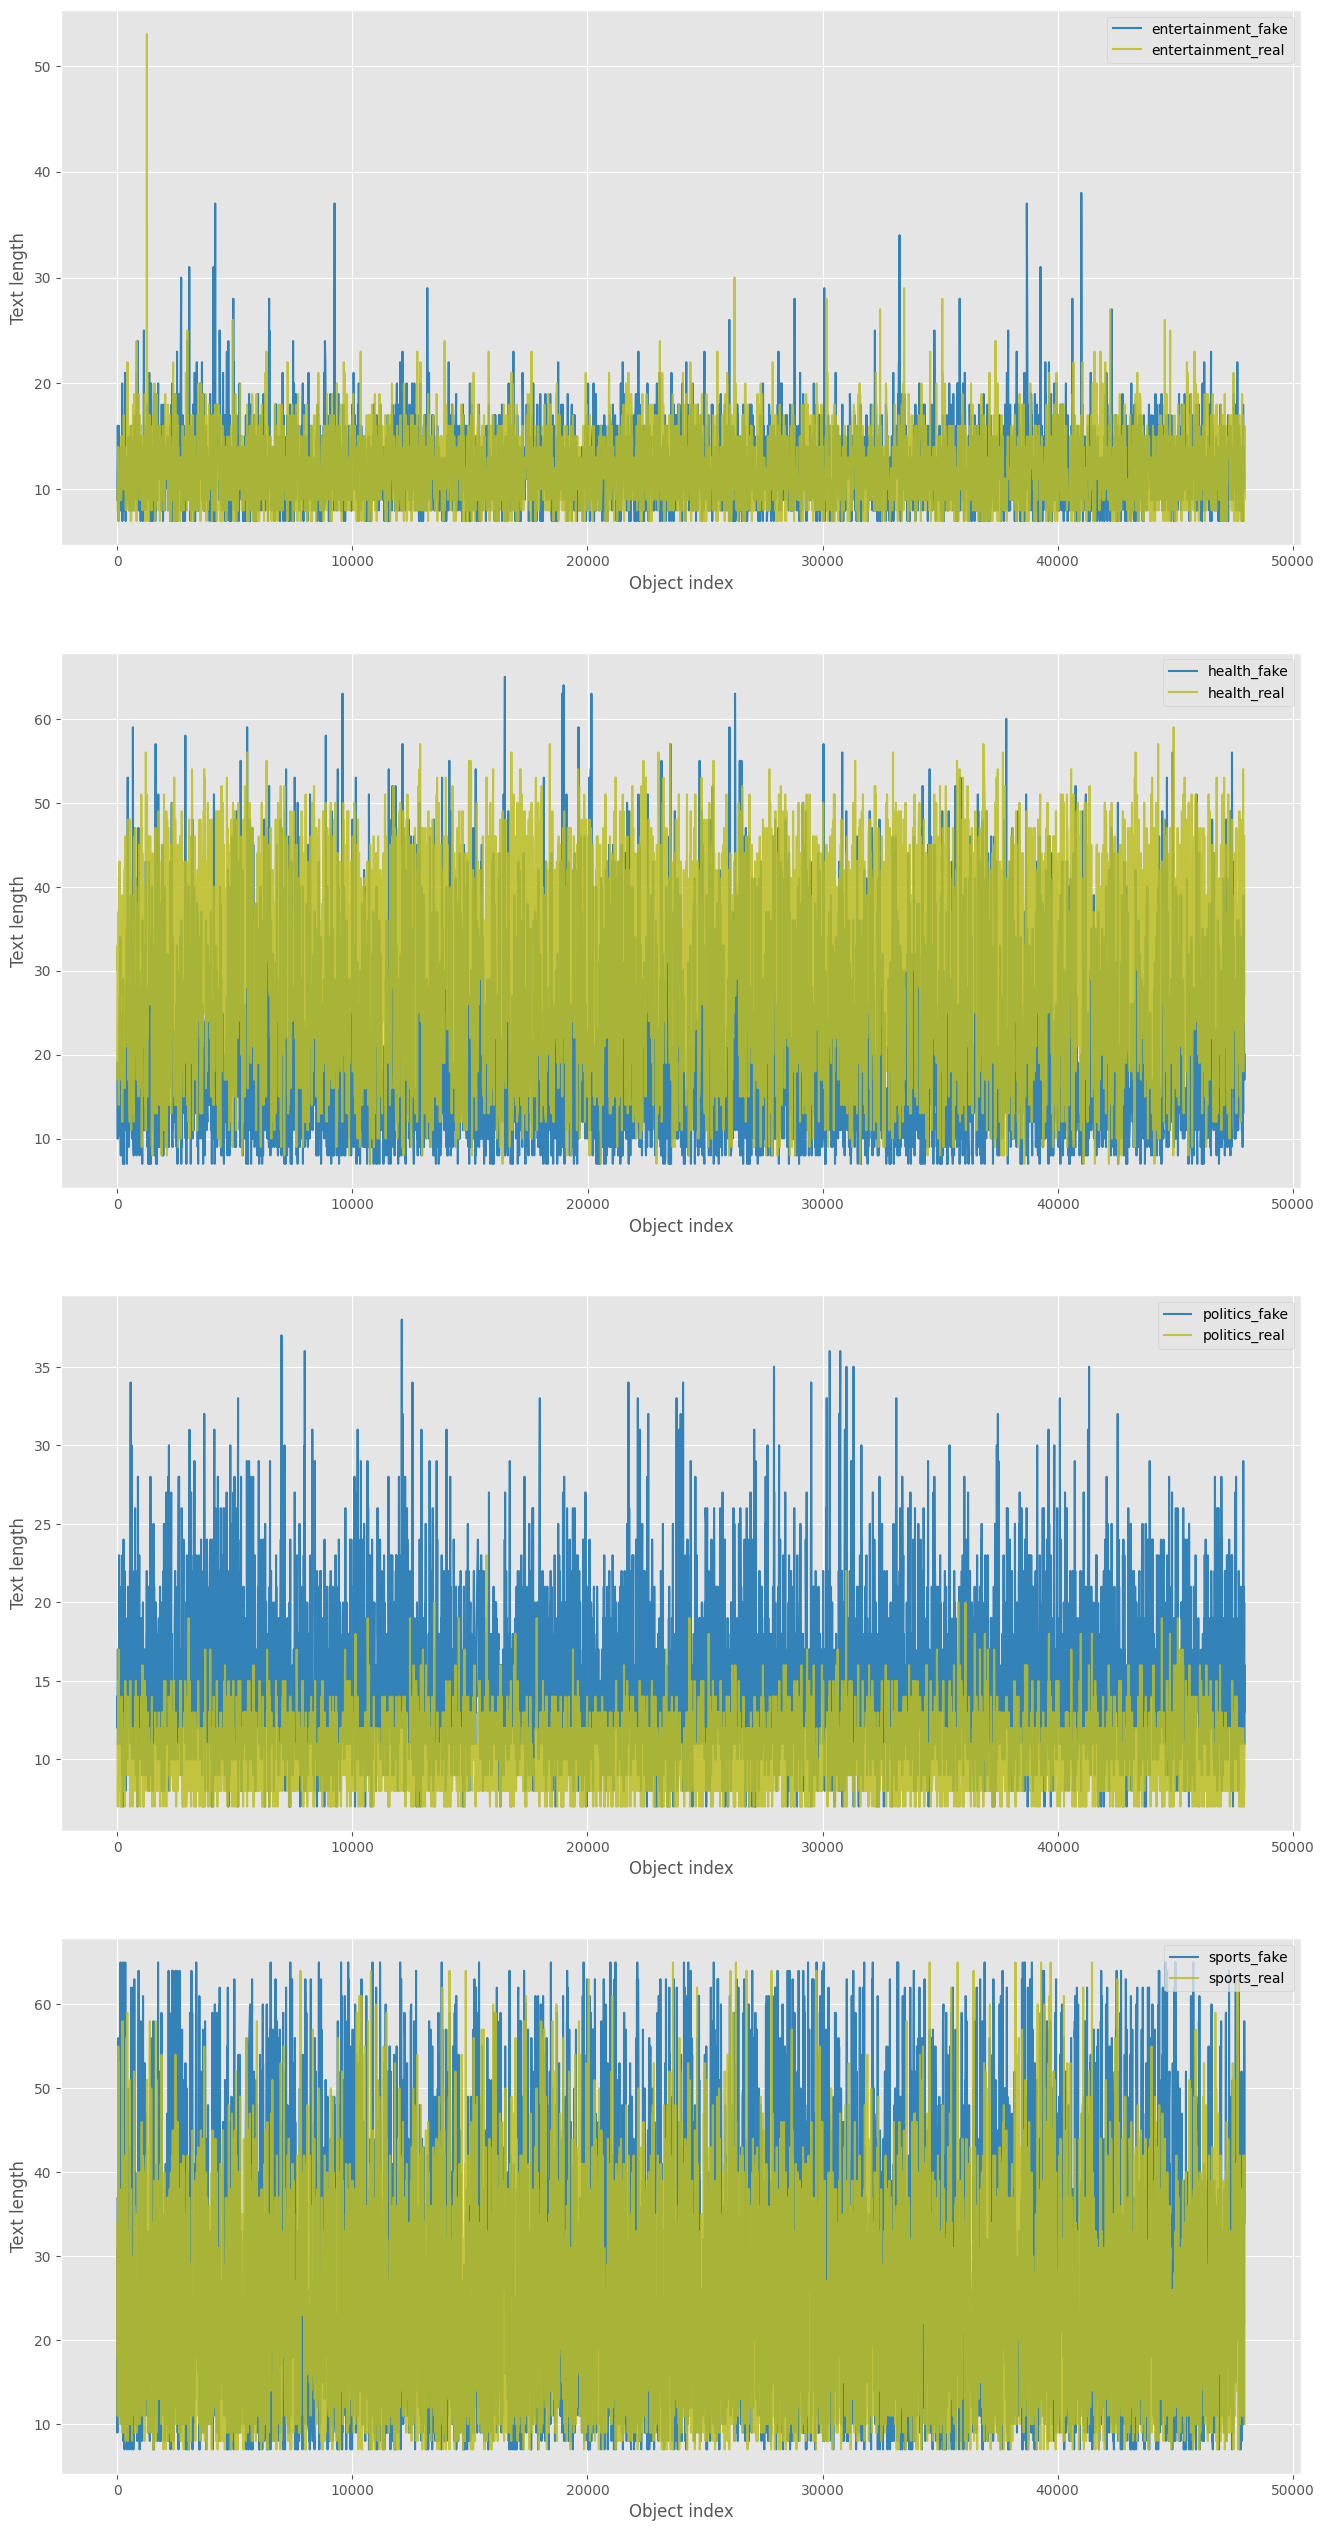

<Figure size 2000x2000 with 0 Axes>

In [14]:
fig, ax = plt.subplots(4, 1, figsize=(16, 32), )
fig = plt.figure(figsize=(20, 20))
unique_labels_ = unique_labels.copy()
unique_labels_.append('fiction_label')
color = []
for i in range(4):
    lbl = unique_labels_.pop(0)
    ax[i].plot(df[df['label']==lbl]['text_length'], 'tab:blue', alpha=.9, label=lbl)
    lbl = unique_labels_.pop(0)
    ax[i].plot(df[df['label']==lbl]['text_length'], 'tab:olive', alpha=.85, label=lbl)
    ax[i].legend()
    ax[i].set_ylabel('Text length')
    ax[i].set_xlabel('Object index')
    

After analyzing the length distribution we can notice that fake news are generally longer than real news excluding the health category.

## Text cleaning

In [15]:
def remove_URL(text):
    """
        Remove URLs from a sample string
    """
    return re.sub(r"https?://\S+|www\.\S+", "", text)

def remove_html(text):
    """
        Remove the html in sample text
    """
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)

def remove_non_ascii(text):
    """
        Remove non-ASCII characters 
    """
    return re.sub(r'[^\x00-\x7f]',r'', text)

def remove_special_characters(text):
    """
        Remove special special characters, including symbols, emojis, and other graphic characters
    """
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_hashtag(text):
    return re.sub(r'#([^\s]+)', r'\1', text)# hashtag symbol

def remove_punct(text):
    """
        Remove the punctuation
    """
    return re.sub(r'[]!"$%&\'()*+,/:;=#@?[\\^_`{|}~-]+', "", text) # exclude a dot
#     return text.translate(str.maketrans('', '', string.punctuation)) # include a dot

def other_clean(text):
        """
            Other manual text cleaning techniques
        """
        # Typos, slang and other
        sample_typos_slang = {
                                "w/e": "whatever",
                                "usagov": "usa government",
                                "recentlu": "recently",
                                "ph0tos": "photos",
                                "amirite": "am i right",
                                "exp0sed": "exposed",
                                "<3": "love",
                                "luv": "love",
                                "amageddon": "armageddon",
                                "trfc": "traffic",
                                "16yr": "16 year"
                                }

        # Acronyms
        sample_acronyms =  { 
                            "mh370": "malaysia airlines flight 370",
                            "okwx": "oklahoma city weather",
                            "arwx": "arkansas weather",    
                            "gawx": "georgia weather",  
                            "scwx": "south carolina weather",  
                            "cawx": "california weather",
                            "tnwx": "tennessee weather",
                            "azwx": "arizona weather",  
                            "alwx": "alabama weather",
                            "usnwsgov": "united states national weather service",
                            "2mw": "tomorrow"
                            }

        
        # Some common abbreviations 
        sample_abbr = {
                        "$" : " dollar ",
                        "€" : " euro ",
                        "4ao" : "for adults only",
                        "a.m" : "before midday",
                        "a3" : "anytime anywhere anyplace",
                        "aamof" : "as a matter of fact",
                        "acct" : "account",
                        "adih" : "another day in hell",
                        "afaic" : "as far as i am concerned",
                        "afaict" : "as far as i can tell",
                        "afaik" : "as far as i know",
                        "afair" : "as far as i remember",
                        "afk" : "away from keyboard",
                        "app" : "application",
                        "approx" : "approximately",
                        "apps" : "applications",
                        "asap" : "as soon as possible",
                        "asl" : "age, sex, location",
                        "atk" : "at the keyboard",
                        "ave." : "avenue",
                        "aymm" : "are you my mother",
                        "ayor" : "at your own risk", 
                        "b&b" : "bed and breakfast",
                        "b+b" : "bed and breakfast",
                        "b.c" : "before christ",
                        "b2b" : "business to business",
                        "b2c" : "business to customer",
                        "b4" : "before",
                        "b4n" : "bye for now",
                        "b@u" : "back at you",
                        "bae" : "before anyone else",
                        "bak" : "back at keyboard",
                        "bbbg" : "bye bye be good",
                        "bbc" : "british broadcasting corporation",
                        "bbias" : "be back in a second",
                        "bbl" : "be back later",
                        "bbs" : "be back soon",
                        "be4" : "before",
                        "bfn" : "bye for now",
                        "blvd" : "boulevard",
                        "bout" : "about",
                        "brb" : "be right back",
                        "bros" : "brothers",
                        "brt" : "be right there",
                        "bsaaw" : "big smile and a wink",
                        "btw" : "by the way",
                        "bwl" : "bursting with laughter",
                        "c/o" : "care of",
                        "cet" : "central european time",
                        "cf" : "compare",
                        "cia" : "central intelligence agency",
                        "csl" : "can not stop laughing",
                        "cu" : "see you",
                        "cul8r" : "see you later",
                        "cv" : "curriculum vitae",
                        "cwot" : "complete waste of time",
                        "cya" : "see you",
                        "cyt" : "see you tomorrow",
                        "dae" : "does anyone else",
                        "dbmib" : "do not bother me i am busy",
                        "diy" : "do it yourself",
                        "dm" : "direct message",
                        "dwh" : "during work hours",
                        "e123" : "easy as one two three",
                        "eet" : "eastern european time",
                        "eg" : "example",
                        "embm" : "early morning business meeting",
                        "encl" : "enclosed",
                        "encl." : "enclosed",
                        "etc" : "and so on",
                        "faq" : "frequently asked questions",
                        "fawc" : "for anyone who cares",
                        "fb" : "facebook",
                        "fc" : "fingers crossed",
                        "fig" : "figure",
                        "fimh" : "forever in my heart", 
                        "ft." : "feet",
                        "ft" : "featuring",
                        "ftl" : "for the loss",
                        "ftw" : "for the win",
                        "fwiw" : "for what it is worth",
                        "fyi" : "for your information",
                        "g9" : "genius",
                        "gahoy" : "get a hold of yourself",
                        "gal" : "get a life",
                        "gcse" : "general certificate of secondary education",
                        "gfn" : "gone for now",
                        "gg" : "good game",
                        "gl" : "good luck",
                        "glhf" : "good luck have fun",
                        "gmt" : "greenwich mean time",
                        "gmta" : "great minds think alike",
                        "gn" : "good night",
                        "g.o.a.t" : "greatest of all time",
                        "goat" : "greatest of all time",
                        "goi" : "get over it",
                        "gps" : "global positioning system",
                        "gr8" : "great",
                        "gratz" : "congratulations",
                        "gyal" : "girl",
                        "h&c" : "hot and cold",
                        "hp" : "horsepower",
                        "hr" : "hour",
                        "hrh" : "his royal highness",
                        "ht" : "height",
                        "ibrb" : "i will be right back",
                        "ic" : "i see",
                        "icq" : "i seek you",
                        "icymi" : "in case you missed it",
                        "idc" : "i do not care",
                        "idgadf" : "i do not give a damn fuck",
                        "idgaf" : "i do not give a fuck",
                        "idk" : "i do not know",
                        "ie" : "that is",
                        "i.e" : "that is",
                        "ifyp" : "i feel your pain",
                        "IG" : "instagram",
                        "iirc" : "if i remember correctly",
                        "ilu" : "i love you",
                        "ily" : "i love you",
                        "imho" : "in my humble opinion",
                        "imo" : "in my opinion",
                        "imu" : "i miss you",
                        "iow" : "in other words",
                        "irl" : "in real life",
                        "j4f" : "just for fun",
                        "jic" : "just in case",
                        "jk" : "just kidding",
                        "jsyk" : "just so you know",
                        "l8r" : "later",
                        "lb" : "pound",
                        "lbs" : "pounds",
                        "ldr" : "long distance relationship",
                        "lmao" : "laugh my ass off",
                        "lmfao" : "laugh my fucking ass off",
                        "lol" : "laughing out loud",
                        "ltd" : "limited",
                        "ltns" : "long time no see",
                        "m8" : "mate",
                        "mf" : "motherfucker",
                        "mfs" : "motherfuckers",
                        "mfw" : "my face when",
                        "mofo" : "motherfucker",
                        "mph" : "miles per hour",
                        "mr" : "mister",
                        "mrw" : "my reaction when",
                        "ms" : "miss",
                        "mte" : "my thoughts exactly",
                        "nagi" : "not a good idea",
                        "nbc" : "national broadcasting company",
                        "nbd" : "not big deal",
                        "nfs" : "not for sale",
                        "ngl" : "not going to lie",
                        "nhs" : "national health service",
                        "nrn" : "no reply necessary",
                        "nsfl" : "not safe for life",
                        "nsfw" : "not safe for work",
                        "nth" : "nice to have",
                        "nvr" : "never",
                        "nyc" : "new york city",
                        "oc" : "original content",
                        "og" : "original",
                        "ohp" : "overhead projector",
                        "oic" : "oh i see",
                        "omdb" : "over my dead body",
                        "omg" : "oh my god",
                        "omw" : "on my way",
                        "p.a" : "per annum",
                        "p.m" : "after midday",
                        "pm" : "prime minister",
                        "poc" : "people of color",
                        "pov" : "point of view",
                        "pp" : "pages",
                        "ppl" : "people",
                        "prw" : "parents are watching",
                        "ps" : "postscript",
                        "pt" : "point",
                        "ptb" : "please text back",
                        "pto" : "please turn over",
                        "qpsa" : "what happens", #"que pasa",
                        "ratchet" : "rude",
                        "rbtl" : "read between the lines",
                        "rlrt" : "real life retweet", 
                        "rofl" : "rolling on the floor laughing",
                        "roflol" : "rolling on the floor laughing out loud",
                        "rotflmao" : "rolling on the floor laughing my ass off",
                        "rt" : "retweet",
                        "ruok" : "are you ok",
                        "sfw" : "safe for work",
                        "sk8" : "skate",
                        "smh" : "shake my head",
                        "sq" : "square",
                        "srsly" : "seriously", 
                        "ssdd" : "same stuff different day",
                        "tbh" : "to be honest",
                        "tbs" : "tablespooful",
                        "tbsp" : "tablespooful",
                        "tfw" : "that feeling when",
                        "thks" : "thank you",
                        "tho" : "though",
                        "thx" : "thank you",
                        "tia" : "thanks in advance",
                        "til" : "today i learned",
                        "tl;dr" : "too long i did not read",
                        "tldr" : "too long i did not read",
                        "tmb" : "tweet me back",
                        "tntl" : "trying not to laugh",
                        "ttyl" : "talk to you later",
                        "u.s." : 'usa',
                        "u" : "you",
                        "u2" : "you too",
                        "u4e" : "yours for ever",
                        "utc" : "coordinated universal time",
                        "w/" : "with",
                        "w/o" : "without",
                        "w8" : "wait",
                        "wassup" : "what is up",
                        "wb" : "welcome back",
                        "wtf" : "what the fuck",
                        "wtg" : "way to go",
                        "wtpa" : "where the party at",
                        "wuf" : "where are you from",
                        "wuzup" : "what is up",
                        "wywh" : "wish you were here",
                        "yd" : "yard",
                        "ygtr" : "you got that right",
                        "ynk" : "you never know",
                        "zzz" : "sleeping bored and tired"
                        }
            
        sample_typos_slang_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_typos_slang.keys()) + r')(?!\w)')
        sample_acronyms_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_acronyms.keys()) + r')(?!\w)')
        sample_abbr_pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in sample_abbr.keys()) + r')(?!\w)')
        
        text = sample_typos_slang_pattern.sub(lambda x: sample_typos_slang[x.group()], text)
        text = sample_acronyms_pattern.sub(lambda x: sample_acronyms[x.group()], text)
        text = sample_abbr_pattern.sub(lambda x: sample_abbr[x.group()], text)
        
        return text
    
def remove_digits(text):
    """
        Remove the digits
    """
    return ''.join([i for i in text if not i.isdigit()])

def fix_spelling(text):
    return str(TextBlob(text).correct())
    
def fix_contractions(text):
    """
        Fix the contractions
    """
    return contractions.fix(text)

def transform_text(text):
    text = remove_URL(text)
    text = remove_html(text)
    text = remove_non_ascii(text)
    text = remove_special_characters(text)
    text = remove_hashtag(text)
    text = remove_punct(text)
    text = text.lower()
    text = other_clean(text)
    text = contractions.fix(text)
    text = text.lower()
    text = text.strip()
    return text

In [16]:
transform_text('Members of the #FYF911 or #FukYoFlag and #BlackLivesMatter movements ain"t called for the lynching and hanging of white people and cops. They encouraged others on a radio show Tuesday night to  turn the tide  and kill white people and cops to send a message about the killing of black people in America.One of the F***YoFlag organizers is called  Sunshine.  She has a radio blog show hosted from Texas called,  Sunshine s F***ing ')

'members of the fyf911 or fukyoflag and blacklivesmatter movements are not called for the lynching and hanging of white people and cops. they encouraged others on a radio show tuesday night to  turn the tide  and kill white people and cops to send a message about the killing of black people in america.one of the fyoflag organizers is called  sunshine.  she has a radio blog show hosted from texas called  sunshine s fing'

In [17]:
df['text2'] = df.text.apply(transform_text)

In [18]:
for i in range(34600, 39000):
    print('BEFORE:')
    print('-----------------')
    print(df['text'].iloc[i])
    print('-----------------')
    print('AFTER:')
    print('-----------------')
    print(df['text2'].iloc[i])
    break

BEFORE:
-----------------
Do not use a face shield without a face mask. A face shield alone cannot prevent the spread of infectious diseases like #COVID19. Remember to: ✅Wear a face mask ✅Wash your hands with soap under running water ✅Cough/sneeze into your elbow #TakeResponsibility https://t.co/m8QgZdJk9d
-----------------
AFTER:
-----------------
do not use a face shield without a face mask. a face shield alone cannot prevent the spread of infectious diseases like covid19. remember to wear a face mask wash your hands with soap under running water coughsneeze into your elbow takeresponsibility


# Preprocessing

## Evaluating

In [19]:
def plot_conf_matrix(y_test, y_preds, save=True):
    cm = confusion_matrix(y_test, y_preds)
    class_names = unique_labels # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="BuPu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    if save==True:
        now_time = strftime("%Y-%m-%d %H-%M-%S", gmtime())
        # сохраняем в отдельную переменную текущую рабочую директорию
        current_path = os.getcwd()
        # создаем новую папку для сохранения графика
        new_path = os.path.join(current_path, 'results', 'graphs', now_time)
        os.makedirs(new_path, exist_ok=True)
        # меняем текущую рабочую директорию на созданную папку
        os.chdir(new_path)
        # сохраняем график
        fig.savefig(f'conf_matrix {now_time}.png')
        # меняем текущую рабочую директорию обратно
        os.chdir(current_path)
        
    plt.show()


def plot_roc_auc(y_test, y_preds_proba, save=True):

    model_auc = roc_auc_score(y_test, y_preds_proba, multi_class='ovr', average='weighted')
    print(f'ROC AUC={model_auc:.4f}')
    # рассчитываем roc-кривую
    fpr = {}
    tpr = {}
    thresh ={}
    n_class = y_preds_proba.shape[1]

    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red',
              'tab:purple', 'tab:brown', 'tab:olive', 'tab:cyan']
    plt.figure(figsize=(8, 6))
    for i in range(n_class):    
        fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_preds_proba[:,i], pos_label=i)
        plt.plot(fpr[i], tpr[i], linestyle='--', color=colors[i],
                 label=f'{labels_int2str[i]} vs Rest (area = {auc(fpr[i], tpr[i]):0.2f})')
        
    plt.plot([0, 1], [0, 1], color='tab:gray', linestyle='--')
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    
    if save==True:
        now_time = strftime("%Y-%m-%d %H-%M-%S", gmtime())
        # сохраняем в отдельную переменную текущую рабочую директорию
        current_path = os.getcwd()
        # создаем новую папку для сохранения графика
        new_path = os.path.join(current_path, 'results', 'graphs', now_time)
        os.makedirs(new_path, exist_ok=True)
        # меняем текущую рабочую директорию на созданную папку
        os.chdir(new_path)
        # сохраняем график
        plt.savefig(f'roc_curve {now_time}.png')
        # меняем текущую рабочую директорию обратно
        os.chdir(current_path)
        
    plt.show()

def custom_evaluate(y_test, y_preds, y_preds_proba, save=True):
    
    if save:
        plot_conf_matrix(y_test, y_preds)
        plot_roc_auc(y_test, y_preds_proba)
    else:
        plot_conf_matrix(y_test, y_preds, save=False)
        plot_roc_auc(y_test, y_preds_proba, save=False)
        
    print(classification_report(y_test, y_preds, target_names=labels_str2int.keys()))
    print(f'Accuracy: {accuracy_score(y_test, y_preds)}')
    print(f'f1_score: {f1_score(y_test, y_preds, average="weighted")}')

## Splitting the dataset

In [19]:
df_X, df_y = df['text'], df['label']
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.15, random_state=42, shuffle=True)

print('\t\t X   |   y')
print(f'Train:      {X_train.shape} | {y_train.shape}')
print(f'Test:       {X_test.shape} | {y_test.shape}')
print()

for lbl in unique_labels:
    print(f'Train {lbl}: {y_train[y_train==lbl].shape}')
    print(f'Test {lbl}: {y_test[y_test==lbl].shape}')
    print()

		 X   |   y
Train:      (40756,) | (40756,)
Test:       (7193,) | (7193,)

Train entertainment_fake: (4340,)
Test entertainment_fake: (765,)

Train entertainment_real: (4411,)
Test entertainment_real: (792,)

Train health_fake: (4657,)
Test health_fake: (775,)

Train health_real: (4779,)
Test health_real: (879,)

Train politics_fake: (5893,)
Test politics_fake: (1052,)

Train politics_real: (5845,)
Test politics_real: (1042,)

Train sports_fake: (5057,)
Test sports_fake: (874,)

Train sports_real: (5774,)
Test sports_real: (1014,)



## Vectorization

In [20]:
tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

print('\t\t     X     |   y')
print(f'Train:      {X_train.shape} | {y_train.shape}')
print(f'Test:       {X_test.shape} | {y_test.shape}')

		     X     |   y
Train:      (40756, 39478) | (40756,)
Test:       (7193, 39478) | (7193,)


In [21]:
labels_int2str = dict(enumerate(unique_labels))
labels_str2int = {v: k for k, v in labels_int2str.items()}

In [22]:
print(labels_int2str)
print(labels_str2int)

{0: 'entertainment_fake', 1: 'entertainment_real', 2: 'health_fake', 3: 'health_real', 4: 'politics_fake', 5: 'politics_real', 6: 'sports_fake', 7: 'sports_real'}
{'entertainment_fake': 0, 'entertainment_real': 1, 'health_fake': 2, 'health_real': 3, 'politics_fake': 4, 'politics_real': 5, 'sports_fake': 6, 'sports_real': 7}


In [23]:
y_train = y_train.apply(lambda x: labels_str2int[x])
y_test = y_test.apply(lambda x: labels_str2int[x])

# Training

## Logistic Regression

C:\ProgramData\Anaconda3\envs\pytorch_1\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


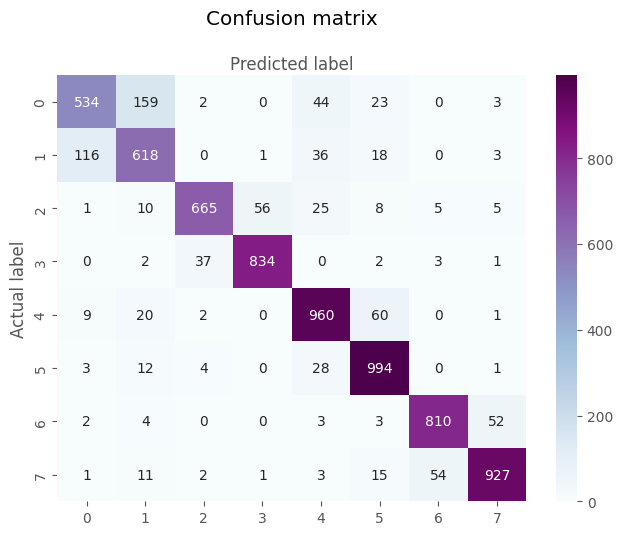

ROC AUC=0.9892


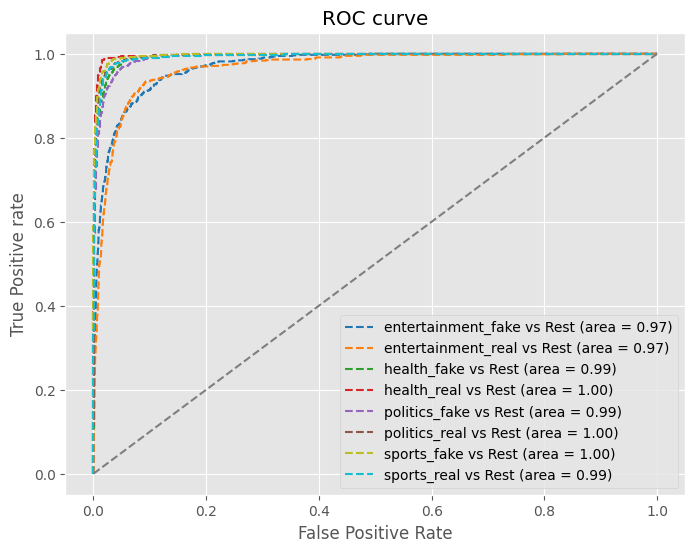

                    precision    recall  f1-score   support

entertainment_fake       0.80      0.70      0.75       765
entertainment_real       0.74      0.78      0.76       792
       health_fake       0.93      0.86      0.89       775
       health_real       0.93      0.95      0.94       879
     politics_fake       0.87      0.91      0.89      1052
     politics_real       0.89      0.95      0.92      1042
       sports_fake       0.93      0.93      0.93       874
       sports_real       0.93      0.91      0.92      1014

          accuracy                           0.88      7193
         macro avg       0.88      0.87      0.88      7193
      weighted avg       0.88      0.88      0.88      7193

Accuracy: 0.8816905324621159
f1_score: 0.8809613633671112


In [34]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)
y_preds_proba = lr.predict_proba(X_test)
custom_evaluate(y_test, y_preds, y_preds_proba)

### Hyperparameters tuning

In [28]:
param_distributions_lr = {
    'C': optuna.distributions.CategoricalDistribution([1.0, 10.0, 50.0, 100.0]),
    'solver': optuna.distributions.CategoricalDistribution(['liblinear', 'lbfgs']),
    'max_iter': optuna.distributions.IntDistribution(100, 250, step=50)
}

In [29]:
lr_for_optuna = LogisticRegression(random_state=42)
optuna_search_lr = optuna.integration.OptunaSearchCV(lr_for_optuna, param_distributions_lr, random_state=42)
optuna_search_lr.fit(X_train, y_train) 

C:\Users\Home\AppData\Local\Temp\ipykernel_46480\1506839034.py:2: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search_lr = optuna.integration.OptunaSearchCV(lr_for_optuna, param_distributions_lr, random_state=42)
[I 2023-05-09 18:24:15,819] A new study created in memory with name: no-name-0241587f-9ea7-4a1d-b117-c2b7f6658a69
[I 2023-05-09 18:24:21,801] Trial 0 finished with value: 0.8868142936037156 and parameters: {'C': 10.0, 'solver': 'liblinear', 'max_iter': 100}. Best is trial 0 with value: 0.8868142936037156.
[I 2023-05-09 18:24:30,292] Trial 1 finished with value: 0.8788155008223704 and parameters: {'C': 100.0, 'solver': 'liblinear', 'max_iter': 100}. Best is trial 0 with value: 0.8868142936037156.
C:\ProgramData\Anaconda3\envs\pytorch_1\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED 

OptunaSearchCV(estimator=LogisticRegression(random_state=42),
               param_distributions={'C': CategoricalDistribution(choices=(1.0, 10.0, 50.0, 100.0)),
                                    'max_iter': IntDistribution(high=250, log=False, low=100, step=50),
                                    'solver': CategoricalDistribution(choices=('liblinear', 'lbfgs'))},
               random_state=42)

In [30]:
y_preds = optuna_search_lr.best_estimator_.predict(X_test)
y_preds_proba = optuna_search_lr.best_estimator_.predict_proba(X_test)

In [32]:
best_params_lr = optuna_search_lr.best_params_
print(f'Logistic regression best params: {best_params_lr}')

Logistic regression best params: {'C': 10.0, 'solver': 'liblinear', 'max_iter': 100}


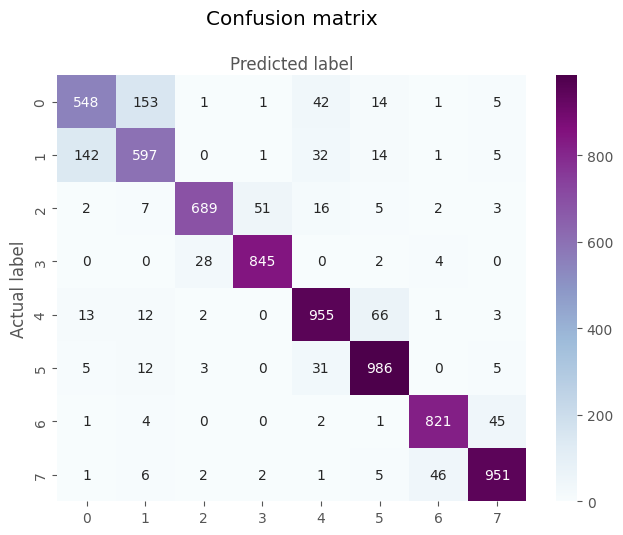

ROC AUC=0.9895


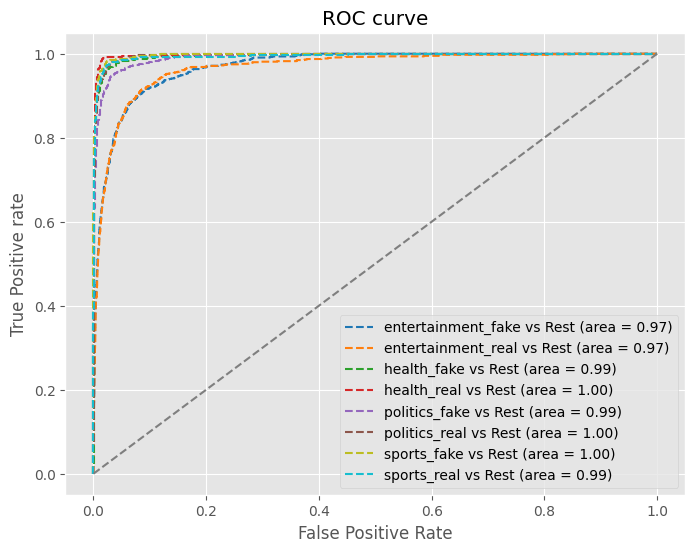

                    precision    recall  f1-score   support

entertainment_fake       0.77      0.72      0.74       765
entertainment_real       0.75      0.75      0.75       792
       health_fake       0.95      0.89      0.92       775
       health_real       0.94      0.96      0.95       879
     politics_fake       0.89      0.91      0.90      1052
     politics_real       0.90      0.95      0.92      1042
       sports_fake       0.94      0.94      0.94       874
       sports_real       0.94      0.94      0.94      1014

          accuracy                           0.89      7193
         macro avg       0.88      0.88      0.88      7193
      weighted avg       0.89      0.89      0.89      7193

Accuracy: 0.8886417350201585
f1_score: 0.887951779625342


In [33]:
custom_evaluate(y_test, y_preds, y_preds_proba)

## Random Forest

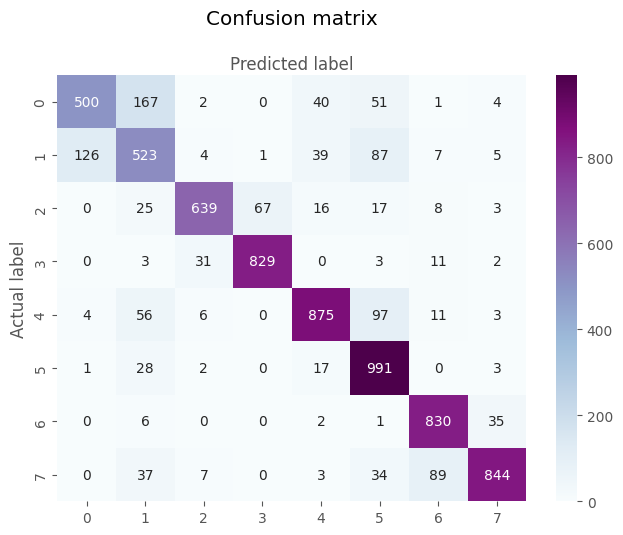

ROC AUC=0.9829


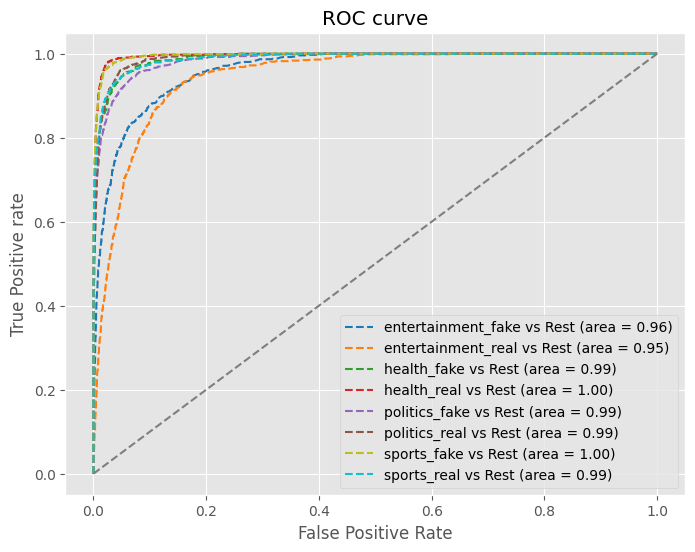

                    precision    recall  f1-score   support

entertainment_fake       0.79      0.65      0.72       765
entertainment_real       0.62      0.66      0.64       792
       health_fake       0.92      0.82      0.87       775
       health_real       0.92      0.94      0.93       879
     politics_fake       0.88      0.83      0.86      1052
     politics_real       0.77      0.95      0.85      1042
       sports_fake       0.87      0.95      0.91       874
       sports_real       0.94      0.83      0.88      1014

          accuracy                           0.84      7193
         macro avg       0.84      0.83      0.83      7193
      weighted avg       0.84      0.84      0.84      7193

Accuracy: 0.8384540525510913
f1_score: 0.8379136458832995


In [35]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
y_preds = rfc.predict(X_test)
y_preds_proba = rfc.predict_proba(X_test)
custom_evaluate(y_test, y_preds, y_preds_proba)

### Hyperparameters tuning

In [39]:
param_distributions_rfc = {
    'n_estimators': optuna.distributions.CategoricalDistribution([50, 100, 200, 300, 500]),
    # 'max_depth': optuna.distributions.IntDistribution(4, 15),
    'n_jobs': optuna.distributions.IntDistribution(-1, -1),
}

In [40]:
optuna_search_rfc = optuna.integration.OptunaSearchCV(rfc, param_distributions_rfc, random_state=42)
optuna_search_rfc.fit(X_train, y_train)

C:\Users\Home\AppData\Local\Temp\ipykernel_46480\3204039297.py:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search_rfc = optuna.integration.OptunaSearchCV(rfc, param_distributions_rfc, random_state=42)
[I 2023-05-09 20:10:53,620] A new study created in memory with name: no-name-db66ed51-a7ee-4dd8-bee9-d070eff942ce
[I 2023-05-09 20:13:21,085] Trial 0 finished with value: 0.8398519137491813 and parameters: {'n_estimators': 100, 'n_jobs': -1}. Best is trial 0 with value: 0.8398519137491813.
[I 2023-05-09 20:25:12,792] Trial 1 finished with value: 0.8433851713770106 and parameters: {'n_estimators': 500, 'n_jobs': -1}. Best is trial 1 with value: 0.8433851713770106.
[I 2023-05-09 20:27:37,687] Trial 2 finished with value: 0.8398519137491813 and parameters: {'n_estimators': 100, 'n_jobs': -1}. Best is trial 1 with value: 0.8433851713770106.
[I 2023-05-09 20:32:22,551] Trial 3 finished with value: 0.842820772

OptunaSearchCV(estimator=RandomForestClassifier(random_state=42),
               param_distributions={'n_estimators': CategoricalDistribution(choices=(50, 100, 200, 300, 500)),
                                    'n_jobs': IntDistribution(high=-1, log=False, low=-1, step=1)},
               random_state=42)

In [41]:
y_preds = optuna_search_rfc.best_estimator_.predict(X_test)
y_preds_proba = optuna_search_rfc.best_estimator_.predict_proba(X_test)

In [42]:
best_params_rfc = optuna_search_rfc.best_params_
print(f'Random forest best params: {best_params_rfc}')

Random forest best params: {'n_estimators': 500, 'n_jobs': -1}


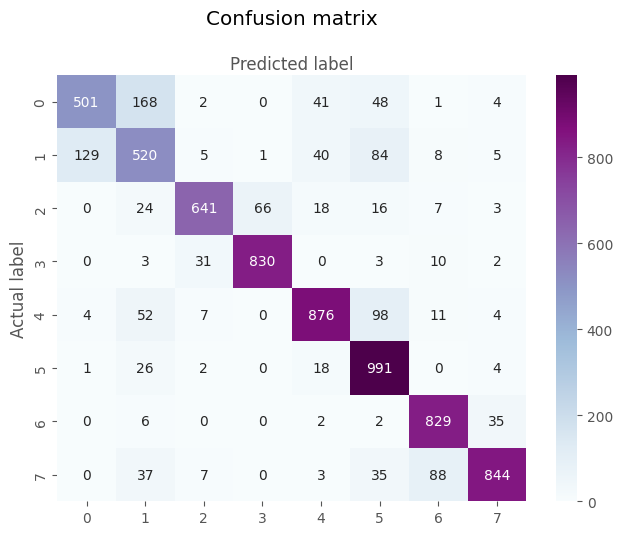

ROC AUC=0.9827


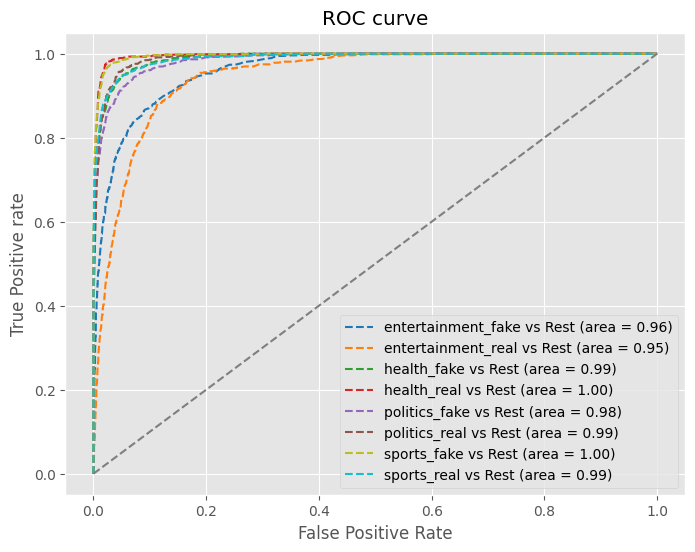

                    precision    recall  f1-score   support

entertainment_fake       0.79      0.65      0.72       765
entertainment_real       0.62      0.66      0.64       792
       health_fake       0.92      0.83      0.87       775
       health_real       0.93      0.94      0.93       879
     politics_fake       0.88      0.83      0.85      1052
     politics_real       0.78      0.95      0.85      1042
       sports_fake       0.87      0.95      0.91       874
       sports_real       0.94      0.83      0.88      1014

          accuracy                           0.84      7193
         macro avg       0.84      0.83      0.83      7193
      weighted avg       0.84      0.84      0.84      7193

Accuracy: 0.8385930766022522
f1_score: 0.8379135909131568


In [43]:
custom_evaluate(y_test, y_preds, y_preds_proba)

## Catboost

In [31]:
catboostclf = CatBoostClassifier(iterations=1000,
                           task_type="GPU",
                           devices='0:1')
catboostclf.fit(X_train,
          y_train,
          verbose=False)

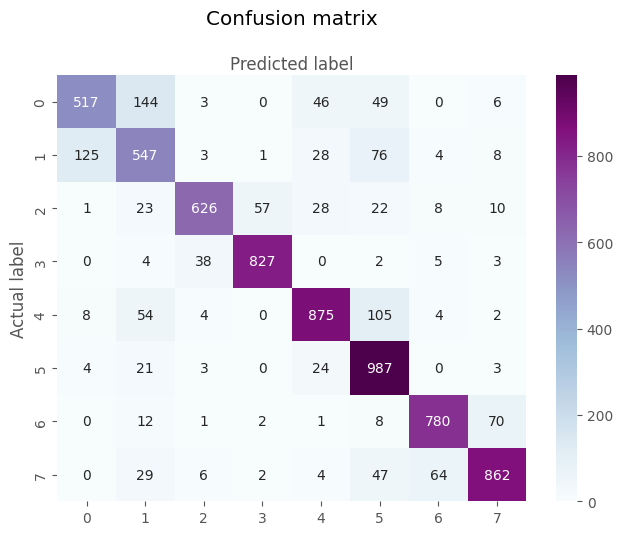

ROC AUC=0.9817


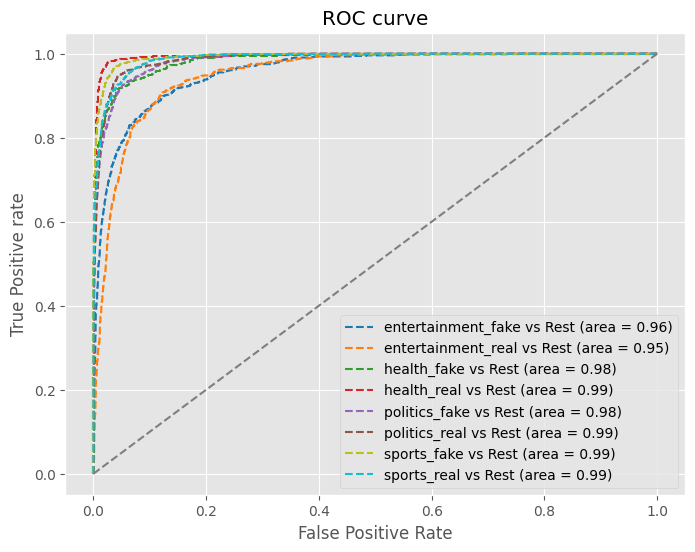

                    precision    recall  f1-score   support

entertainment_fake       0.79      0.68      0.73       765
entertainment_real       0.66      0.69      0.67       792
       health_fake       0.92      0.81      0.86       775
       health_real       0.93      0.94      0.94       879
     politics_fake       0.87      0.83      0.85      1052
     politics_real       0.76      0.95      0.84      1042
       sports_fake       0.90      0.89      0.90       874
       sports_real       0.89      0.85      0.87      1014

          accuracy                           0.84      7193
         macro avg       0.84      0.83      0.83      7193
      weighted avg       0.84      0.84      0.84      7193

Accuracy: 0.8370638120394829
f1_score: 0.8368474713286395


In [32]:
y_preds = catboostclf.predict(X_test)
y_preds_proba = catboostclf.predict_proba(X_test)
custom_evaluate(y_test, y_preds, y_preds_proba)

## SVM

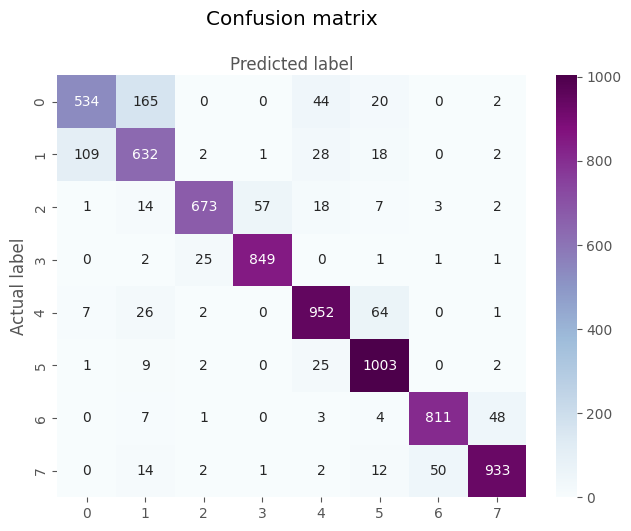

ROC AUC=0.9827


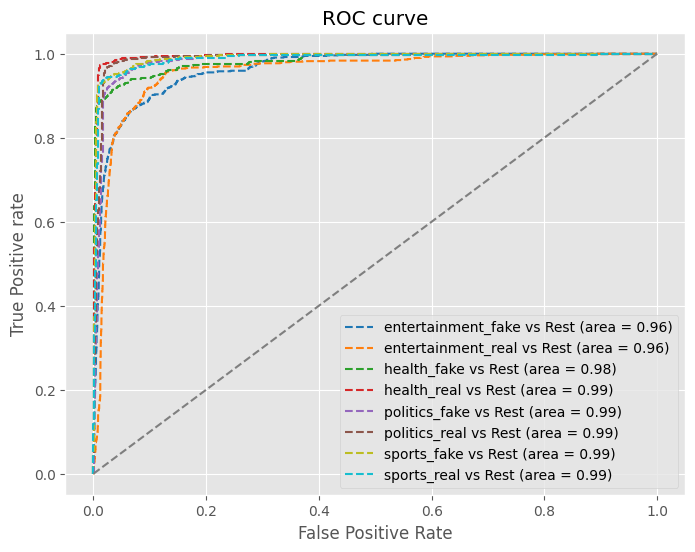

                    precision    recall  f1-score   support

entertainment_fake       0.82      0.70      0.75       765
entertainment_real       0.73      0.80      0.76       792
       health_fake       0.95      0.87      0.91       775
       health_real       0.94      0.97      0.95       879
     politics_fake       0.89      0.90      0.90      1052
     politics_real       0.89      0.96      0.92      1042
       sports_fake       0.94      0.93      0.93       874
       sports_real       0.94      0.92      0.93      1014

          accuracy                           0.89      7193
         macro avg       0.89      0.88      0.88      7193
      weighted avg       0.89      0.89      0.89      7193

Accuracy: 0.8879466147643542
f1_score: 0.8874086217937438


In [44]:
svm = SVC(random_state=42, probability=True)
svm.fit(X_train, y_train)
y_preds = svm.predict(X_test)
y_preds_proba = svm.predict_proba(X_test)
custom_evaluate(y_test, y_preds, y_preds_proba)

### Hyperparameters tuning

In [45]:
svm_for_optuna = SVC(random_state=42, probability=True)
param_distributions_svm = {
    'C': optuna.distributions.CategoricalDistribution([1, 10, 100, 1000]),
    'kernel': optuna.distributions.CategoricalDistribution(['linear', 'poly', 'rbf', 'sigmoid']),
}

In [46]:
optuna_search_svm = optuna.integration.OptunaSearchCV(svm_for_optuna, param_distributions_svm, random_state=42)
optuna_search_svm.fit(X_train, y_train)

C:\Users\Home\AppData\Local\Temp\ipykernel_46480\2339597083.py:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search_svm = optuna.integration.OptunaSearchCV(svm_for_optuna, param_distributions_svm, random_state=42)
[I 2023-05-09 21:15:17,133] A new study created in memory with name: no-name-44c6eb4a-3618-4f20-8ecf-b43ac49ffc8d
[I 2023-05-09 21:17:47,703] Trial 0 finished with value: 0.8738835966471419 and parameters: {'C': 10, 'kernel': 'linear'}. Best is trial 0 with value: 0.8738835966471419.
[I 2023-05-09 21:20:24,217] Trial 1 finished with value: 0.8676513499069152 and parameters: {'C': 1000, 'kernel': 'linear'}. Best is trial 0 with value: 0.8738835966471419.
[I 2023-05-09 21:27:43,900] Trial 2 finished with value: 0.7702424273727408 and parameters: {'C': 10, 'kernel': 'poly'}. Best is trial 0 with value: 0.8738835966471419.
[I 2023-05-09 21:35:03,121] Trial 3 finished with value: 0.7702424273727408

OptunaSearchCV(estimator=SVC(probability=True, random_state=42),
               param_distributions={'C': CategoricalDistribution(choices=(1, 10, 100, 1000)),
                                    'kernel': CategoricalDistribution(choices=('linear', 'poly', 'rbf', 'sigmoid'))},
               random_state=42)

In [47]:
y_preds = optuna_search_svm.best_estimator_.predict(X_test)
y_preds_proba = optuna_search_svm.best_estimator_.predict_proba(X_test)

In [48]:
best_params_svm = optuna_search_svm.best_params_
print(f'Random forest best params: {best_params_svm}')

Random forest best params: {'C': 1000, 'kernel': 'rbf'}


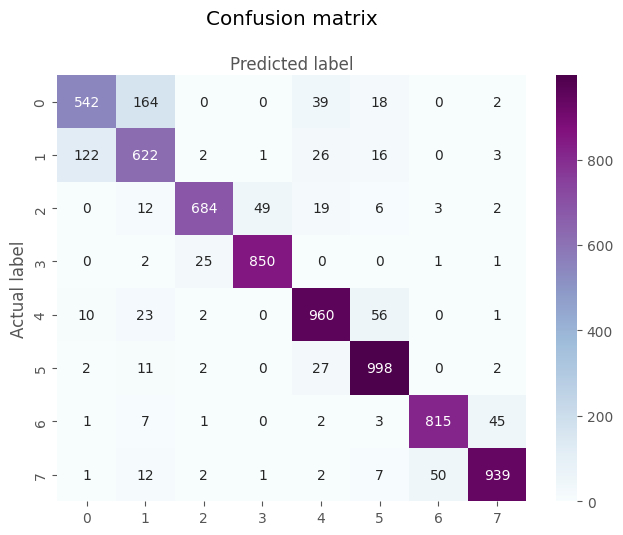

ROC AUC=0.9835


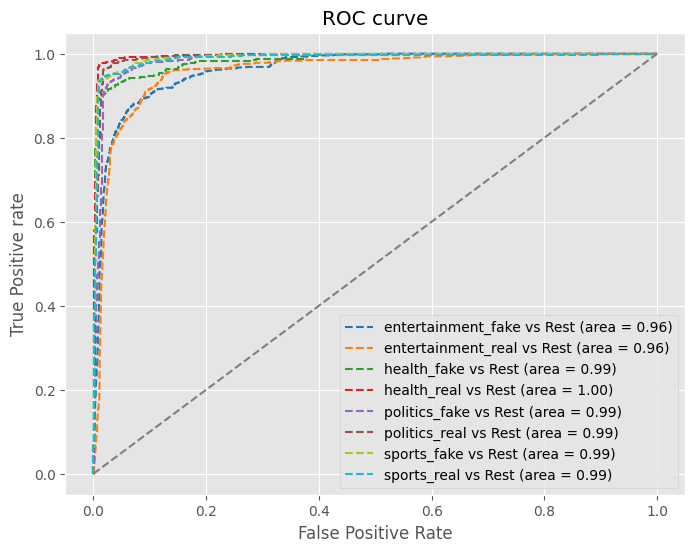

                    precision    recall  f1-score   support

entertainment_fake       0.80      0.71      0.75       765
entertainment_real       0.73      0.79      0.76       792
       health_fake       0.95      0.88      0.92       775
       health_real       0.94      0.97      0.96       879
     politics_fake       0.89      0.91      0.90      1052
     politics_real       0.90      0.96      0.93      1042
       sports_fake       0.94      0.93      0.94       874
       sports_real       0.94      0.93      0.93      1014

          accuracy                           0.89      7193
         macro avg       0.89      0.88      0.89      7193
      weighted avg       0.89      0.89      0.89      7193

Accuracy: 0.8911441679410538
f1_score: 0.890758434652053


In [49]:
custom_evaluate(y_test, y_preds, y_preds_proba)

## LSTM

In [36]:
df_ = df[['text', 'label']]

df_['label'] = df_['label'].apply(lambda x: labels_str2int[x])

data_train, data_test = train_test_split(df_, test_size=0.15, random_state=42, shuffle=True)

print('\t\t Shape')
print(f'Train:      {data_train.shape}')
print(f'Test:       {data_test.shape}')
print()

for lbl in unique_labels:
    print(f'Train {lbl}: {data_train[data_train["label"]==labels_str2int[lbl]].shape}')
    print(f'Test {lbl}: {data_test[data_test["label"]==labels_str2int[lbl]].shape}')
    print()

		 Shape
Train:      (40756, 2)
Test:       (7193, 2)

Train entertainment_fake: (4340, 2)
Test entertainment_fake: (765, 2)

Train entertainment_real: (4411, 2)
Test entertainment_real: (792, 2)

Train health_fake: (4657, 2)
Test health_fake: (775, 2)

Train health_real: (4779, 2)
Test health_real: (879, 2)

Train politics_fake: (5893, 2)
Test politics_fake: (1052, 2)

Train politics_real: (5845, 2)
Test politics_real: (1042, 2)

Train sports_fake: (5057, 2)
Test sports_fake: (874, 2)

Train sports_real: (5774, 2)
Test sports_real: (1014, 2)



C:\Users\Home\AppData\Local\Temp\ipykernel_67908\1939291414.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['label'] = df_['label'].apply(lambda x: labels_str2int[x])


In [37]:
data_train, data_val = train_test_split(data_train, test_size=0.15, random_state=42, shuffle=True)

print('\t\t Shape')
print(f'Train:      {data_train.shape}')
print(f'Test:       {data_test.shape}')
print()

for lbl in unique_labels:
    print(f'Train {lbl}: {data_train[data_train["label"]==labels_str2int[lbl]].shape}')
    print(f'Valid {lbl}: {data_val[data_val["label"]==labels_str2int[lbl]].shape}')
    print(f'Test {lbl}: {data_test[data_test["label"]==labels_str2int[lbl]].shape}')
    print()

		 Shape
Train:      (34642, 2)
Test:       (7193, 2)

Train entertainment_fake: (3712, 2)
Valid entertainment_fake: (628, 2)
Test entertainment_fake: (765, 2)

Train entertainment_real: (3747, 2)
Valid entertainment_real: (664, 2)
Test entertainment_real: (792, 2)

Train health_fake: (3952, 2)
Valid health_fake: (705, 2)
Test health_fake: (775, 2)

Train health_real: (4090, 2)
Valid health_real: (689, 2)
Test health_real: (879, 2)

Train politics_fake: (4969, 2)
Valid politics_fake: (924, 2)
Test politics_fake: (1052, 2)

Train politics_real: (4967, 2)
Valid politics_real: (878, 2)
Test politics_real: (1042, 2)

Train sports_fake: (4305, 2)
Valid sports_fake: (752, 2)
Test sports_fake: (874, 2)

Train sports_real: (4900, 2)
Valid sports_real: (874, 2)
Test sports_real: (1014, 2)



In [38]:
tokenizer = get_tokenizer('basic_english')

def build_vocabulary(datasets):
    for dataset in datasets:
        for text in dataset['text']:
            yield tokenizer(text)

vocab = build_vocab_from_iterator(build_vocabulary([data_train, data_val]), specials=['<UNK>'])
vocab.set_default_index(vocab['<UNK>'])

In [39]:
print(f'Vocabulary length: {vocab.__len__()}')

Vocabulary length: 51677


In [256]:
# PARAMETERS

# for data_loader
MAX_WORDS  = 50
BATCH_SIZE = 1024

# for model
EMBED_LEN     = 100
HIDDEN_DIM    = 100
N_LAYERS      = 2
TRAIN_ON_GPU  = torch.cuda.is_available()
EPOCHS        = 10
LR            = 1e-2
BIDIRECTIONAL = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# for saving checkpoints
# PATH = Path('checkpoints_lstm')
# PATH.mkdir(exist_ok=True)

cuda


In [257]:
train_dataset, val_dataset, test_dataset = to_map_style_dataset(data_train.values), \
                                           to_map_style_dataset(data_val.values), \
                                           to_map_style_dataset(data_test.values), \

def vectorize_batch(batch):
    X, Y = list(zip(*batch))
    X = [vocab(tokenizer(text)) for text in X] # tokenize and map tokens to indexes
    X = [tokens+([0]*(MAX_WORDS - len(tokens))) if len(tokens) < MAX_WORDS else tokens[:MAX_WORDS] for tokens in X]
    return torch.tensor(X, dtype=torch.int32, device=device), torch.tensor(Y, device=device)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=vectorize_batch, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, collate_fn=vectorize_batch, shuffle=True)
test_loader  = DataLoader(test_dataset , batch_size=BATCH_SIZE, collate_fn=vectorize_batch, shuffle=True)

In [258]:
target_classes = labels_int2str.keys()


class LSTMClassifier(nn.Module):
    def __init__(self):
        super(LSTMClassifier, self).__init__()
        # двунаправленная модель или нет
        self.num_directions = (2 if BIDIRECTIONAL else 1)
        # слой построения векторных представлений (эмбеддингов)
        self.emb_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=EMBED_LEN)
        # рекуррентный слой
        self.lstm = nn.LSTM(input_size=EMBED_LEN, hidden_size=HIDDEN_DIM, num_layers=N_LAYERS, dropout=0.5,
                            batch_first=True, bidirectional=BIDIRECTIONAL)
        # полносвязный слой
        self.fc = nn.Linear(in_features=HIDDEN_DIM*self.num_directions, out_features=len(target_classes))
        # применение log(Softmax(x)) функции для выражения результатов в виде вероятностей
        self.softmax = nn.LogSoftmax(dim=1)

    def init_hidden(self, batch_size):
        '''Инициализация скрытого состояния'''
        
        # создание двух тензоров для hidden и cell состояний LSTM размерности num_layers x batch_size x hidden_size,
        # с весами, инициализированными по формуле Ксавье
        weight = next(self.parameters()).data

        if (TRAIN_ON_GPU):
            hidden = (xavier_uniform_(weight.new(self.num_directions*N_LAYERS, batch_size, HIDDEN_DIM)).cuda(),
                    xavier_uniform_(weight.new(self.num_directions*N_LAYERS, batch_size, HIDDEN_DIM)).cuda())
        else:
            hidden = (xavier_uniform_(weight.new(self.num_directions*N_LAYERS, batch_size, HIDDEN_DIM)),
                    xavier_uniform_(weight.new(self.num_directions*N_LAYERS, batch_size, HIDDEN_DIM)))
        return hidden

    def forward(self, X_batch, hidden):
        """Описание прямого распространения ошибки"""
        
        emb = self.emb_layer(X_batch)
        output, hidden = self.lstm(emb, hidden)
        output = self.fc(output[:, -1])
        output = self.softmax(output)
        return output, hidden

In [259]:
lstm_classifier = LSTMClassifier()

print(lstm_classifier)

LSTMClassifier(
  (emb_layer): Embedding(51677, 100)
  (lstm): LSTM(100, 100, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=200, out_features=8, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [260]:
for layer in lstm_classifier.children():
    print(f'Layer: {layer}')
    print('Parameters: ')
    for param in layer.parameters():
        print(param.shape)
    print()

Layer: Embedding(51677, 100)
Parameters: 
torch.Size([51677, 100])

Layer: LSTM(100, 100, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
Parameters: 
torch.Size([400, 100])
torch.Size([400, 100])
torch.Size([400])
torch.Size([400])
torch.Size([400, 100])
torch.Size([400, 100])
torch.Size([400])
torch.Size([400])
torch.Size([400, 200])
torch.Size([400, 100])
torch.Size([400])
torch.Size([400])
torch.Size([400, 200])
torch.Size([400, 100])
torch.Size([400])
torch.Size([400])

Layer: Linear(in_features=200, out_features=8, bias=True)
Parameters: 
torch.Size([8, 200])
torch.Size([8])

Layer: LogSoftmax(dim=1)
Parameters: 



In [261]:
def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    """Цикл валидации"""
    
    # на валидации не нужно проводить обновление градиентов
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [], [], []
        
        for X, Y in val_loader:

            # инициализация скрытого состояния
            h = model.init_hidden(X.shape[0])
            # предсказание и обновление скрытого состояния
            preds, h = model(X, h)
            # вычисление функции потерь
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))
        
        # список тензоров "вытягиваем" в вектор единичной размерности
        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)
        
        # вычисление среднего значения функции потерь
        valid_loss = torch.tensor(losses).cpu().mean()
        # вычисление метрики качества
        valid_acc = accuracy_score(Y_shuffled.cpu().detach().numpy(), Y_preds.cpu().detach().numpy())

        print(f'Valid Loss: {valid_loss:.3f}')
        print(f'Valid Acc : {valid_acc:.3f}')

        return valid_loss, valid_acc


def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, device, epochs=10):
    """Цикл обучения"""
    
    train_losses, val_losses, val_accs = [], [], []
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            X.to(device)
            Y.to(device)
            model.to(device)

            # инициализация скрытого состояния
            h = model.init_hidden(X.shape[0])
            
            # предсказание и обновление скрытого состояния
            Y_preds, h = model(X, h)
            
            # вычисление функции потерь
            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())
            
            # обнуление градиентов
            optimizer.zero_grad()
            
            # обратное распространение ошибки для вычисления градиентов
            loss.backward()
            
            # шаг оптимизатора для обновления весов модели
            optimizer.step()
        
        # вычисление среднего значения функции потерь на тренировочной выборке
        train_loss = torch.tensor(losses).mean()
        print(f'Train Loss: {train_loss:.3f}')
        # вычисление функции потерь и метрики качества на валидационной выборке
        valid_loss, valid_acc = CalcValLossAndAccuracy(model, loss_fn, val_loader)

        # сохранение значений функции потерь и метрики качества
        train_losses.append(train_loss)
        val_losses.append(valid_loss)
        val_accs.append(valid_acc)
    
    # построение графиков обучения
    plt.plot(train_losses, label='train loss')
    plt.plot(val_losses, label='val loss')
    plt.plot(val_accs, label='val accuracy')
    plt.legend()

  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 1.756
Valid Loss: 1.258
Valid Acc : 0.466


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 1.060
Valid Loss: 0.821
Valid Acc : 0.674


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.596
Valid Loss: 0.484
Valid Acc : 0.817


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.349
Valid Loss: 0.393
Valid Acc : 0.863


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.251
Valid Loss: 0.382
Valid Acc : 0.868


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.198
Valid Loss: 0.381
Valid Acc : 0.870


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.172
Valid Loss: 0.389
Valid Acc : 0.873


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.139
Valid Loss: 0.392
Valid Acc : 0.874


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.112
Valid Loss: 0.420
Valid Acc : 0.872


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.112
Valid Loss: 0.411
Valid Acc : 0.880


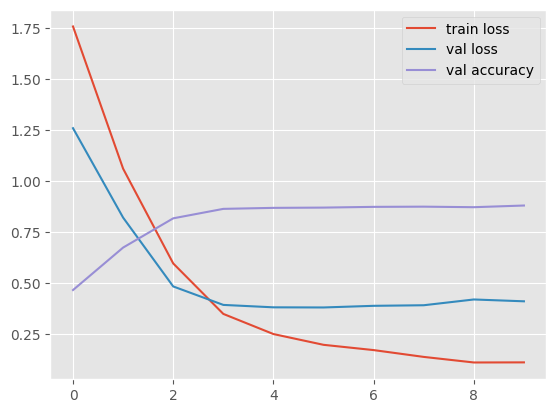

In [262]:
# инициализация оптимизатора
OPT     = Adam(lstm_classifier.parameters(), lr=LR, weight_decay=5e-5)
# инициализация функции потерь
LOSS_FN = nn.CrossEntropyLoss()
# инициализация модели
MODEL   = LSTMClassifier()

# запуск цикла обучения модели
TrainModel(model=MODEL, loss_fn=LOSS_FN, optimizer=OPT, train_loader=train_loader, val_loader=val_loader,
           device=device, epochs=EPOCHS)

In [263]:
MODEL.eval()

def MakePredictions(model, loader, device):
    Y_shuffled, Y_preds= [], []
    for X, Y in loader:
        X.to(device)
        Y.to(device)
        # инициализация скрытого состояния
        h = model.init_hidden(X.shape[0])
        # предсказание и обновления скрытого состояния
        preds, h = model(X, h)
        # сохранение предсказаний
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    gc.collect()
    # списки тензоров "вытягиваем" в векторы единичной размерности
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.cpu().detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1), F.softmax(Y_preds, dim=-1)

# вычисление предсказаний классов и вероятностей принадлежности к классам
Y_actual, Y_preds, Y_preds_proba = MakePredictions(MODEL, test_loader, device)
Y_actual, Y_preds, Y_preds_proba = torch.tensor(Y_actual).cpu(), torch.tensor(Y_preds).cpu(), torch.tensor(Y_preds_proba).cpu()

C:\Users\Home\AppData\Local\Temp\ipykernel_67908\1101836045.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_actual, Y_preds, Y_preds_proba = torch.tensor(Y_actual).cpu(), torch.tensor(Y_preds).cpu(), torch.tensor(Y_preds_proba).cpu()


In [264]:
# демонстрация вектора предсказаний вероятностей
Y_preds_proba[0]

tensor([7.6345e-05, 2.6443e-04, 7.9064e-05, 1.8973e-05, 2.2909e-04, 9.9907e-01,
        1.6486e-06, 2.6030e-04])

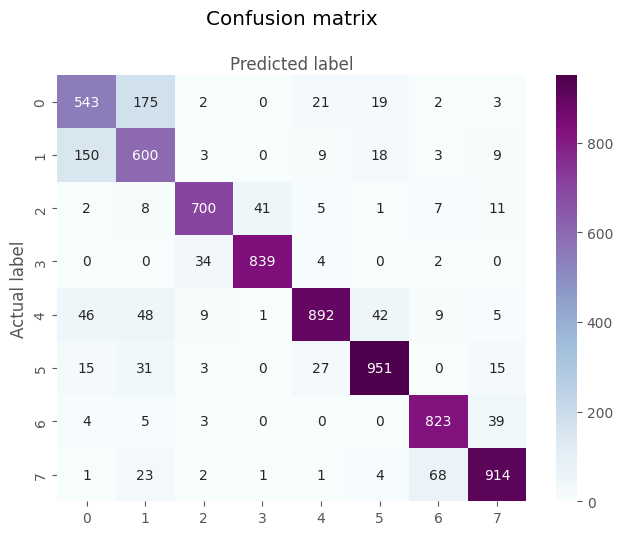

ROC AUC=0.9870


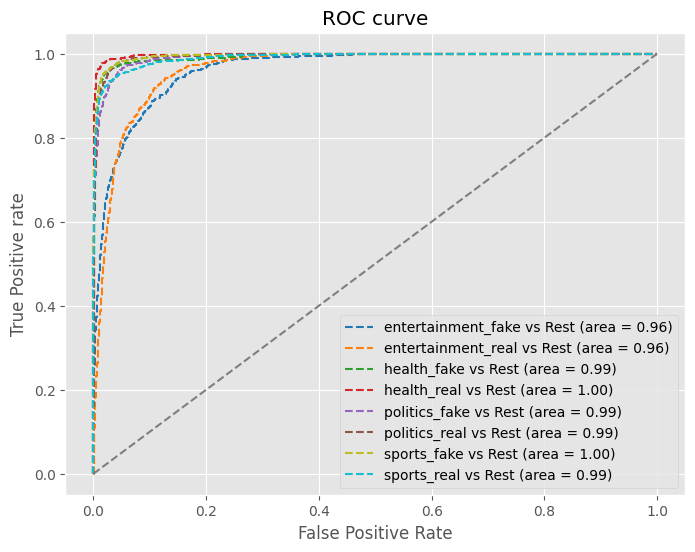

                    precision    recall  f1-score   support

entertainment_fake       0.71      0.71      0.71       765
entertainment_real       0.67      0.76      0.71       792
       health_fake       0.93      0.90      0.91       775
       health_real       0.95      0.95      0.95       879
     politics_fake       0.93      0.85      0.89      1052
     politics_real       0.92      0.91      0.92      1042
       sports_fake       0.90      0.94      0.92       874
       sports_real       0.92      0.90      0.91      1014

          accuracy                           0.87      7193
         macro avg       0.87      0.87      0.87      7193
      weighted avg       0.87      0.87      0.87      7193

Accuracy: 0.8705686083692479
f1_score: 0.8716741889371914


In [265]:
# вычисление и визуализация метрик качества
custom_evaluate(Y_actual, Y_preds, Y_preds_proba)

## Transformer

In [103]:
# PARAMETERS
MAX_WORDS  = 50
BATCH_SIZE = 1024
EPOCHS     = 10
LR         = 1e-2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EMBED_LEN  = 75
HEADS      = 1
DEPTH      = 5

In [104]:
df_ = df[['text', 'label']]

df_['label'] = df_['label'].apply(lambda x: labels_str2int[x])

data_train, data_test = train_test_split(df_, test_size=0.15, random_state=42, shuffle=True)

print('\t\t Shape')
print(f'Train:      {data_train.shape}')
print(f'Test:       {data_test.shape}')
print()

for lbl in unique_labels:
    print(f'Train {lbl}: {data_train[data_train["label"]==labels_str2int[lbl]].shape}')
    print(f'Test {lbl}: {data_test[data_test["label"]==labels_str2int[lbl]].shape}')
    print()

		 Shape
Train:      (40756, 2)
Test:       (7193, 2)

Train entertainment_fake: (4340, 2)
Test entertainment_fake: (765, 2)

Train entertainment_real: (4411, 2)
Test entertainment_real: (792, 2)

Train health_fake: (4657, 2)
Test health_fake: (775, 2)

Train health_real: (4779, 2)
Test health_real: (879, 2)

Train politics_fake: (5893, 2)
Test politics_fake: (1052, 2)

Train politics_real: (5845, 2)
Test politics_real: (1042, 2)

Train sports_fake: (5057, 2)
Test sports_fake: (874, 2)

Train sports_real: (5774, 2)
Test sports_real: (1014, 2)



C:\Users\Home\AppData\Local\Temp\ipykernel_60148\1939291414.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['label'] = df_['label'].apply(lambda x: labels_str2int[x])


In [105]:
data_train, data_val = train_test_split(data_train, test_size=0.15, random_state=42, shuffle=True)

print('\t\t Shape')
print(f'Train:      {data_train.shape}')
print(f'Test:       {data_test.shape}')
print()

for lbl in unique_labels:
    print(f'Train {lbl}: {data_train[data_train["label"]==labels_str2int[lbl]].shape}')
    print(f'Valid {lbl}: {data_val[data_val["label"]==labels_str2int[lbl]].shape}')
    print(f'Test {lbl}: {data_test[data_test["label"]==labels_str2int[lbl]].shape}')
    print()

		 Shape
Train:      (34642, 2)
Test:       (7193, 2)

Train entertainment_fake: (3712, 2)
Valid entertainment_fake: (628, 2)
Test entertainment_fake: (765, 2)

Train entertainment_real: (3747, 2)
Valid entertainment_real: (664, 2)
Test entertainment_real: (792, 2)

Train health_fake: (3952, 2)
Valid health_fake: (705, 2)
Test health_fake: (775, 2)

Train health_real: (4090, 2)
Valid health_real: (689, 2)
Test health_real: (879, 2)

Train politics_fake: (4969, 2)
Valid politics_fake: (924, 2)
Test politics_fake: (1052, 2)

Train politics_real: (4967, 2)
Valid politics_real: (878, 2)
Test politics_real: (1042, 2)

Train sports_fake: (4305, 2)
Valid sports_fake: (752, 2)
Test sports_fake: (874, 2)

Train sports_real: (4900, 2)
Valid sports_real: (874, 2)
Test sports_real: (1014, 2)



In [106]:
tokenizer = get_tokenizer('basic_english')

def build_vocabulary(datasets):
    for dataset in datasets:
        for text in dataset['text']:
            yield tokenizer(text)

vocab = build_vocab_from_iterator(build_vocabulary([data_train, data_val]), specials=['<UNK>'])
vocab.set_default_index(vocab['<UNK>'])

In [107]:
print(f'Vocabulary length: {vocab.__len__()}')

Vocabulary length: 51677


In [108]:
train_dataset, val_dataset, test_dataset = to_map_style_dataset(data_train.values), \
                                           to_map_style_dataset(data_val.values), \
                                           to_map_style_dataset(data_test.values), \

def vectorize_batch(batch):
    X, Y = list(zip(*batch))
    X = [vocab(tokenizer(text)) for text in X] # tokenize and map tokens to indexes
    X = [tokens+([0]*(MAX_WORDS - len(tokens))) if len(tokens) < MAX_WORDS else tokens[:MAX_WORDS] for tokens in X]
    return torch.tensor(X, dtype=torch.int32, device=device), torch.tensor(Y, device=device)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=vectorize_batch, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, collate_fn=vectorize_batch, shuffle=True)
test_loader  = DataLoader(test_dataset , batch_size=BATCH_SIZE, collate_fn=vectorize_batch, shuffle=True)

In [109]:
class ClsTransformer(nn.Module):
    """
    Transformer для классификации последовтельностей данных
    """

    def __init__(self, emb, heads, depth, seq_length, num_tokens, num_classes, max_pool=True, dropout=0.0):
        """
        :param emb: размерность векторных представлений (эмбеддингов)
        :param heads: количество слоев внимания (self-attention) 
        :param depth: количество блоков энкодера
        :param seq_length: ожидаемая максимальная длина входной последовательности
        :param num_tokens: количество токенов в словаре
        :param num_classes: количество классов
        :param max_pool: если значение True, то на последнем слое применяется max pooling,
                         если значение False, то average pooling
        """
        super().__init__()
        self.num_tokens, self.max_pool = num_tokens, max_pool
        # слой веторного представления (эмбеддинга) текста 
        self.token_embedding = nn.Embedding(num_embeddings=num_tokens, embedding_dim=emb)
        # слой векторного представления позиций (позиционного эмбеддинга)
        self.pos_embedding = nn.Embedding(num_embeddings=seq_length, embedding_dim=emb)
        self.unify_embeddings = nn.Linear(2 * emb, emb)

        tblocks = []
        for i in range(depth):
            tblocks.append(
                TransformerBlock(emb=emb, heads=heads, seq_length=seq_length, dropout=dropout))
        
        # последовательность блоков энкодера
        self.tblocks = nn.Sequential(*tblocks)
        self.toprobs = nn.Linear(emb, num_classes)
        # dropout-регуляризация
        self.do = nn.Dropout(dropout)

    def forward(self, x):
        """
        Цикл прямого распространения ошибки

        """
        # векторные представления (эмбеддинги) текстов
        tokens = self.token_embedding(x)
        b, t, e = tokens.size()
        # векторные представления позиций (позиционные эмбеддинги)
        positions = self.pos_embedding(torch.arange(t, device=device))[None, :, :].expand(b, t, e)
        x = self.unify_embeddings(torch.cat((tokens, positions), dim=2).view(-1, 2 * e)).view(b, t, e)
        # применение dropout-регуляризации
        x = self.do(x)
        x = self.tblocks(x)
        # применение max pooling или average pooling
        x = x.max(dim=1)[0] if self.max_pool else x.mean(dim=1)
        x = self.toprobs(x)
        return F.log_softmax(x, dim=1)


class SelfAttention(nn.Module):
    def __init__(self, emb, heads=8):
        """
        :param emb: размерность векторного представления
        :param heads: количество слоев внимания self-attention
        """
        super().__init__()

        self.emb = emb
        self.heads = heads
        
        # создание слоев для хранения параметров для обучения keys, queries и values
        self.tokeys = nn.Linear(emb, emb * heads, bias=False)
        self.toqueries = nn.Linear(emb, emb * heads, bias=False)
        self.tovalues = nn.Linear(emb, emb * heads, bias=False)

        self.unifyheads = nn.Linear(heads * emb, emb)

    def forward(self, x):

        b, t, e = x.size()
        h = self.heads
        assert e == self.emb, f'Input embedding dim ({e}) should match layer embedding dim ({self.emb})'

        keys    = self.tokeys(x)   .view(b, t, h, e)
        queries = self.toqueries(x).view(b, t, h, e)
        values  = self.tovalues(x) .view(b, t, h, e)

        # вычисление масштабированного скалярного произведения self-attention

        # приведение слоев к размерности батча
        keys    = keys   .transpose(1, 2).contiguous().view(b * h, t, e)
        queries = queries.transpose(1, 2).contiguous().view(b * h, t, e)
        values  = values .transpose(1, 2).contiguous().view(b * h, t, e)

        # вычисление скалярного произведения queries и keys и последующее масштабирование
        dot = torch.bmm(queries, keys.transpose(1, 2))
        dot = dot / math.sqrt(e) # dot contains b*h  t-by-t matrices with raw self-attention logits

        assert dot.size() == (b*h, t, t), f'Matrix has size {dot.size()}, expected {(b*h, t, t)}.'

        dot = F.softmax(dot, dim=2)

        # применяем self-attention к values
        out = torch.bmm(dot, values).view(b, h, t, e)

        out = out.transpose(1, 2).contiguous().view(b, t, h * e)

        return self.unifyheads(out)


class TransformerBlock(nn.Module):
    """
    Блок энкодера
    """
    def __init__(self, emb, heads, seq_length, ff_hidden_mult=5, dropout=0.4):
        super().__init__()
        # слой внимания self-attention
        self.attention = SelfAttention(emb, heads=heads)
        # слой нормализации
        self.norm1 = nn.LayerNorm(emb)
        self.norm2 = nn.LayerNorm(emb)
        # полносвязная сеть
        self.ff = nn.Sequential(
            # полносвязный слой
            nn.Linear(emb, ff_hidden_mult * emb),
            # функция активации
            nn.ReLU(),
            nn.Linear(ff_hidden_mult * emb, emb),
            nn.Linear(emb, ff_hidden_mult * emb),
            nn.ReLU(),
            nn.Linear(ff_hidden_mult * emb, emb),
        )
        # dropout-регуляризация
        self.do = nn.Dropout(dropout)

    def forward(self, x):
        attended = self.attention(x)
        x = self.norm1(attended + x)
        x = self.do(x)
        feedforward = self.ff(x)
        x = self.norm2(feedforward + x)
        x = self.do(x)
        return x       

In [111]:
MODEL   = ClsTransformer(
                emb=EMBED_LEN,
                heads=HEADS,
                depth=DEPTH,
                seq_length=MAX_WORDS, 
                num_tokens=len(vocab),
                num_classes=8
            )
OPT     = AdamW(MODEL.parameters(), lr=LR, weight_decay=5e-2)
LR_SCHD = LinearLR(OPT, total_iters=(EPOCHS * len(train_loader)))
LOSS_FN = nn.CrossEntropyLoss()

for epoch in range(1, EPOCHS + 1):
    # цикл обучения
    train_losses, val_losses, val_accs = [], [], []
    MODEL.train()
    for X, Y in tqdm(train_loader):
        X, Y, MODEL = X.to(device), Y.to(device), MODEL.to(device)
        # вычисление предсказаний
        Y_preds = MODEL(X)
        # вычисление функции потерь и сохранение ее значения
        loss = LOSS_FN(Y_preds, Y)
        train_losses.append(loss)
        # обнуление градиентов
        OPT.zero_grad()
        # обратное распространение ошибки
        loss.backward()
        # шаг оптимизатора для обновления параметров модели
        OPT.step()
    # вычисление среднего значения функции потерь на тренировочной выборке
    train_loss = torch.tensor(train_losses).mean()
    print(f'Train Loss: {train_loss:.3f}')

    # цикл валидации
    MODEL.eval()
    # на валидации не нужно проводить обновление градиентов
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [], [], []
        for X, Y in tqdm(val_loader):
            # вычисление предсказаний
            preds = MODEL(X)
            # вычисление функции потерь и сохранение ее значения
            loss = LOSS_FN(preds, Y)
            losses.append(loss)

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds    = torch.cat(Y_preds)
        
        # вычисление средного значения функции потерь и метрики качества на валидационной выборке
        valid_loss = torch.tensor(losses).to(device).mean()
        valid_acc  = accuracy_score(
                        Y_shuffled.cpu().detach().numpy(),
                        Y_preds.cpu().detach().numpy()
                        )
        print(f'Valid Loss: {valid_loss:.3f}')
        print(f'Epoch: {epoch}, Valid Acc : {valid_acc:.3f}')
    
    # шаг планировщика скорости обучения
    LR_SCHD.step()
    
    # сохранение значений функции потерь и метрики качества
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    val_accs.append(valid_acc)

  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 1.582


  0%|          | 0/6 [00:00<?, ?it/s]

Valid Loss: 1.125
Epoch: 1, Valid Acc : 0.575


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.879


  0%|          | 0/6 [00:00<?, ?it/s]

Valid Loss: 0.725
Epoch: 2, Valid Acc : 0.736


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.534


  0%|          | 0/6 [00:00<?, ?it/s]

Valid Loss: 0.494
Epoch: 3, Valid Acc : 0.820


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.367


  0%|          | 0/6 [00:00<?, ?it/s]

Valid Loss: 0.450
Epoch: 4, Valid Acc : 0.834


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.277


  0%|          | 0/6 [00:00<?, ?it/s]

Valid Loss: 0.435
Epoch: 5, Valid Acc : 0.842


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.207


  0%|          | 0/6 [00:00<?, ?it/s]

Valid Loss: 0.430
Epoch: 6, Valid Acc : 0.850


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.155


  0%|          | 0/6 [00:00<?, ?it/s]

Valid Loss: 0.476
Epoch: 7, Valid Acc : 0.850


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.115


  0%|          | 0/6 [00:00<?, ?it/s]

Valid Loss: 0.479
Epoch: 8, Valid Acc : 0.854


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.088


  0%|          | 0/6 [00:00<?, ?it/s]

Valid Loss: 0.515
Epoch: 9, Valid Acc : 0.849


  0%|          | 0/34 [00:00<?, ?it/s]

Train Loss: 0.071


  0%|          | 0/6 [00:00<?, ?it/s]

Valid Loss: 0.536
Epoch: 10, Valid Acc : 0.857


In [112]:
MODEL.eval()

# вычисление прдсказаний на тестовой выборке
def MakePredictions(model, loader, device):
    # градиенты вычислять не нужно
    with torch.no_grad():
        Y_shuffled, Y_preds= [], []
        for X, Y in loader:
            X.to(device)
            Y.to(device)
            # вычисление прдсказаний
            preds = model(X)
            Y_preds.append(preds)
            Y_shuffled.append(Y)
        gc.collect()
        # списки тензоров "вытягиваем" в векторы единичной размерности
        Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

        return Y_shuffled.cpu().detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1), F.softmax(Y_preds, dim=-1)

# вычисление предсказаний классов и вероятностей принадлежности к классам
Y_actual, Y_preds, Y_preds_proba = MakePredictions(MODEL, test_loader, device)
Y_actual, Y_preds, Y_preds_proba = torch.tensor(Y_actual).cpu(), torch.tensor(Y_preds).cpu(), torch.tensor(Y_preds_proba).cpu()

C:\Users\Home\AppData\Local\Temp\ipykernel_60148\2629513944.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_actual, Y_preds, Y_preds_proba = torch.tensor(Y_actual).cpu(), torch.tensor(Y_preds).cpu(), torch.tensor(Y_preds_proba).cpu()


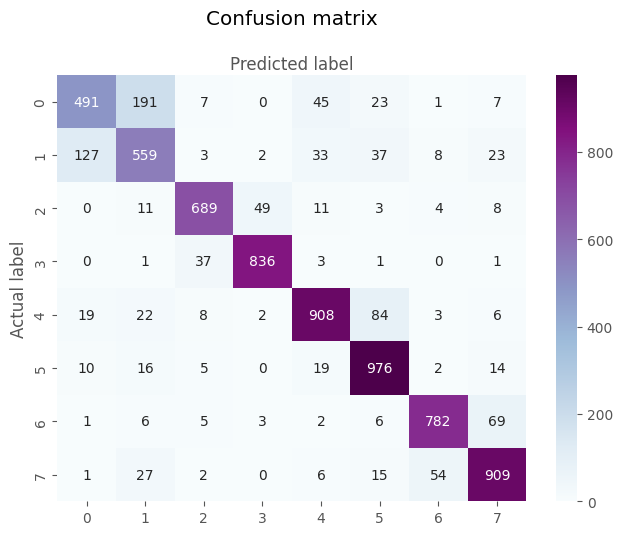

ROC AUC=0.9848


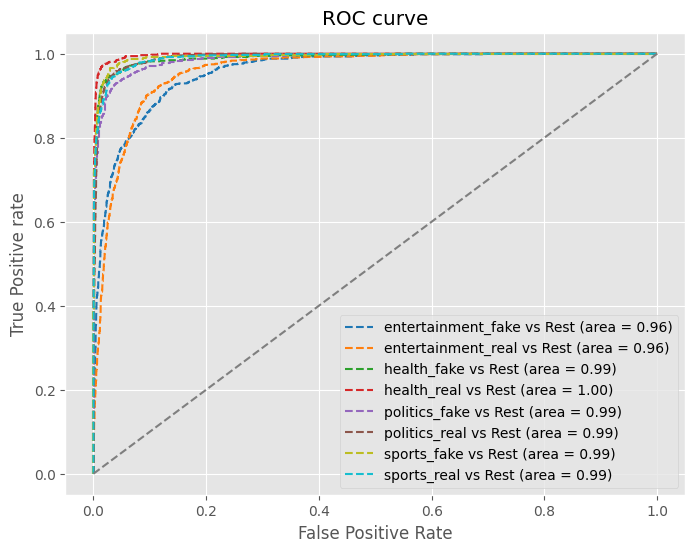

                    precision    recall  f1-score   support

entertainment_fake       0.76      0.64      0.69       765
entertainment_real       0.67      0.71      0.69       792
       health_fake       0.91      0.89      0.90       775
       health_real       0.94      0.95      0.94       879
     politics_fake       0.88      0.86      0.87      1052
     politics_real       0.85      0.94      0.89      1042
       sports_fake       0.92      0.89      0.91       874
       sports_real       0.88      0.90      0.89      1014

          accuracy                           0.85      7193
         macro avg       0.85      0.85      0.85      7193
      weighted avg       0.85      0.85      0.85      7193

Accuracy: 0.8549979146392326
f1_score: 0.8539413235310492


In [113]:
# вычисление и визуализация метрик качества
custom_evaluate(Y_actual, Y_preds, Y_preds_proba)

## bert-base-uncased

In [20]:
# PARAMETERS
CHECKPOINT = "bert-base-uncased"

BATCH_SIZE = 128
NUM_EPOCHS = 10
LR         = 3e-5

In [21]:
labels_int2str = {k: v for k, v in enumerate(unique_labels)}
labels_str2int = {v: k for k, v in labels_int2str.items()}
print(labels_int2str)
print(labels_str2int)

{0: 'entertainment_fake', 1: 'entertainment_real', 2: 'health_fake', 3: 'health_real', 4: 'politics_fake', 5: 'politics_real', 6: 'sports_fake', 7: 'sports_real'}
{'entertainment_fake': 0, 'entertainment_real': 1, 'health_fake': 2, 'health_real': 3, 'politics_fake': 4, 'politics_real': 5, 'sports_fake': 6, 'sports_real': 7}


In [22]:
df_ = df[['text', 'label']]

# label encoding
df_['label'] = df_['label'].apply(lambda x: labels_str2int[x])

data_train, data_test = train_test_split(df_, test_size=0.15, random_state=42, shuffle=True)
data_train, data_val = train_test_split(data_train, test_size=0.15, random_state=42, shuffle=True)

print('\t\t Shape')
print(f'Train:      {data_train.shape}')
print(f'Validation: {data_val.shape}')
print(f'Test:       {data_test.shape}')

		 Shape
Train:      (34642, 2)
Validation: (6114, 2)
Test:       (7193, 2)


C:\Users\Home\AppData\Local\Temp\ipykernel_70132\977235754.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['label'] = df_['label'].apply(lambda x: labels_str2int[x])


In [23]:
# Convert pandas dataframe to Hugging Face arrow dataset
hg_train_data = Dataset.from_pandas(data_train)
hg_val_data = Dataset.from_pandas(data_val)
hg_test_data = Dataset.from_pandas(data_test)

print(hg_train_data)
print(hg_val_data)
print(hg_test_data)

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 34642
})
Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 6114
})
Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 7193
})


In [24]:
# Tokenizer from a pretrained model
tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT)

# Take a look at the tokenizer
tokenizer

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [25]:
# replace id for PAD token from 0 to 105
tokenizer.pad_token_id = 105

In [26]:
# Mapping between special tokens and their IDs.
print(f'The unknown token is {tokenizer.unk_token} and the ID for the unknown token is {tokenizer.unk_token_id}.')
print(f'The seperator token is {tokenizer.sep_token} and the ID for the seperator token is {tokenizer.sep_token_id}.')
print(f'The pad token is {tokenizer.pad_token} and the ID for the pad token is {tokenizer.pad_token_id}.')
print(f'The sentence level classification token is {tokenizer.cls_token} and the ID for the classification token is {tokenizer.cls_token_id}.')
print(f'The mask token is {tokenizer.mask_token} and the ID for the mask token is {tokenizer.mask_token_id}.')

The unknown token is [UNK] and the ID for the unknown token is 100.
The seperator token is [SEP] and the ID for the seperator token is 102.
The pad token is [unused100] and the ID for the pad token is 105.
The sentence level classification token is [CLS] and the ID for the classification token is 101.
The mask token is [MASK] and the ID for the mask token is 103.


In [27]:
# Funtion to tokenize data
def tokenize_function(data):
    return tokenizer(data["text"],
                     max_length=50,
                     truncation=True)

# Tokenize the dataset
dataset_train = hg_train_data.map(tokenize_function, batched=True)
dataset_val   = hg_val_data  .map(tokenize_function, batched=True)
dataset_test  = hg_test_data .map(tokenize_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Take a look at the data
print(dataset_train)
print(dataset_val)
print(dataset_test)

Map:   0%|          | 0/34642 [00:00<?, ? examples/s]

Map:   0%|          | 0/6114 [00:00<?, ? examples/s]

Map:   0%|          | 0/7193 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 34642
})
Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 6114
})
Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 7193
})


In [28]:
# Remove the review and index columns because it will not be used in the model
dataset_train = dataset_train.remove_columns(["text", "__index_level_0__"])
dataset_val   = dataset_val  .remove_columns(["text", "__index_level_0__"])
dataset_test  = dataset_test .remove_columns(["text", "__index_level_0__"])

# Rename label to labels because the model expects the name labels
dataset_train = dataset_train.rename_column("label", "labels")
dataset_val   = dataset_val  .rename_column("label", "labels")
dataset_test  = dataset_test .rename_column("label", "labels")

# Change the format to PyTorch tensors
dataset_train.set_format("torch")
dataset_val  .set_format("torch")
dataset_test .set_format("torch")

# Take a look at the data
print(dataset_train)
print(dataset_val)
print(dataset_test)

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 34642
})
Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 6114
})
Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 7193
})


In [29]:
# Empty cache
torch.cuda.empty_cache()

# DataLoader
train_dataloader = DataLoader(dataset=dataset_train, batch_size=BATCH_SIZE, collate_fn=data_collator,  shuffle=True)
val_dataloader   = DataLoader(dataset=dataset_val,   batch_size=BATCH_SIZE, collate_fn=data_collator)
test_dataloader  = DataLoader(dataset=dataset_test,  batch_size=BATCH_SIZE, collate_fn=data_collator)

In [30]:
# inspect the batch
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'labels': torch.Size([128]),
 'input_ids': torch.Size([128, 50]),
 'token_type_ids': torch.Size([128, 50]),
 'attention_mask': torch.Size([128, 50])}

In [31]:
# инициализация модели
model = AutoModelForSequenceClassification.from_pretrained(CHECKPOINT, num_labels=8)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [32]:
# pass one batch to this model to make sure that everything is ok
outputs = model(**batch)
print(outputs.loss, outputs.logits.shape)

tensor(2.1319, grad_fn=<NllLossBackward0>) torch.Size([128, 8])


In [33]:
# количество шагов обучения для планировщика скорости обучения
num_training_steps = NUM_EPOCHS * len(train_dataloader)

# инициализация оптимизатора
optimizer = AdamW(params=model.parameters(), lr=LR)

# настройка планировщика скорости обучения
lr_scheduler = get_scheduler(name="linear", 
                             optimizer=optimizer, 
                             num_warmup_steps=0, 
                             num_training_steps=num_training_steps)

print(f'Number of the training steps: {num_training_steps}')

Number of the training steps: 2710


In [34]:
# Use GPU if it is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
print(device)

cuda


  0%|          | 0/2710 [00:00<?, ?it/s]

Epoch: 1: {'recall': {'recall': 0.9116781157998037}, 'precision': {'precision': 0.912662888054651}, 'f1': {'f1': 0.9115211969766319}, 'accuracy': {'accuracy': 0.9116781157998037}}
Epoch: 2: {'recall': {'recall': 0.9165848871442591}, 'precision': {'precision': 0.9175282439665261}, 'f1': {'f1': 0.916467591126507}, 'accuracy': {'accuracy': 0.9165848871442591}}
Epoch: 3: {'recall': {'recall': 0.9223094537127903}, 'precision': {'precision': 0.9215029246678851}, 'f1': {'f1': 0.9218365746781035}, 'accuracy': {'accuracy': 0.9223094537127903}}
Epoch: 4: {'recall': {'recall': 0.9213280994438993}, 'precision': {'precision': 0.9225529595864573}, 'f1': {'f1': 0.9212759013836349}, 'accuracy': {'accuracy': 0.9213280994438993}}
Epoch: 5: {'recall': {'recall': 0.925744193653909}, 'precision': {'precision': 0.9254173938854577}, 'f1': {'f1': 0.9255144393072676}, 'accuracy': {'accuracy': 0.925744193653909}}
Epoch: 6: {'recall': {'recall': 0.9237814851161269}, 'precision': {'precision': 0.9233200469463663}

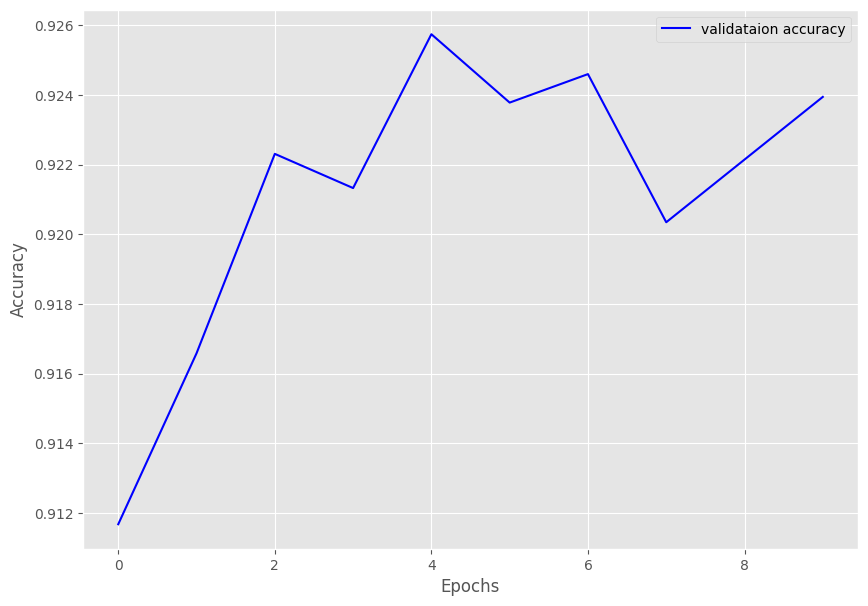

In [35]:
# загрузка готовых реализаций метрик качества
recall_metric    = evaluate.load('recall')
precision_metric = evaluate.load('precision')
f1_metric        = evaluate.load('f1')
accuracy_metric  = evaluate.load('accuracy')

# настройка визуализации шкалы выполнения обучения
progress_bar = tqdm(range(num_training_steps))

# списки для хранения результатов метрик качества
best_accuracy = 0
prec_list_to_plot = []
rec_list_to_plot  = []
f1_list_to_plot   = []
acc_list_to_plot  = []


for epoch in range(1, NUM_EPOCHS + 1):
    # цикл обучения
    model.train()
    for batch in train_dataloader:
        # получение батча данных
        batch = {k: v.to(device) for k, v in batch.items()}
        # вычисление выхода модели
        outputs = model(**batch)
        # вычисление функции потерь
        loss = outputs.loss
        # обратное распространение ошибки
        loss.backward()
        # шаг оптимизатора для обновления параметров
        optimizer.step()
        # шаг планировщика скорости обучения
        lr_scheduler.step()
        # обнуление градиентов
        optimizer.zero_grad()
        # обновление шкалы выполнения обучения
        progress_bar.update(1)

    # цикл валидации
    model.eval()
    for batch in val_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        # вычислять градиенты не требуется
        with torch.no_grad():
            # вычисление выхода модели
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        
        # вычисление метрик качества в рамках батча
        recall_metric   .add_batch(predictions=predictions, references=batch['labels'])
        precision_metric.add_batch(predictions=predictions, references=batch['labels'])
        f1_metric       .add_batch(predictions=predictions, references=batch['labels'])
        accuracy_metric .add_batch(predictions=predictions, references=batch['labels'])
    
    # вычисление взвешенных усредненных метрик качества в рамках всей валидационной выборки
    results = {
        'recall':    recall_metric   .compute(average='weighted'),
        'precision': precision_metric.compute(average='weighted'),
        'f1':        f1_metric       .compute(average='weighted'),
        'accuracy':  accuracy_metric .compute()
    }
    
    print(
        f'Epoch: {epoch}:',
        {
            key: value
            for key, value in results.items()
        },
    )

    # добавление рассчитанных метрика качества в списки
    prec_list_to_plot.append(results['recall'])
    rec_list_to_plot .append(results['precision'])
    f1_list_to_plot  .append(results['f1'])
    acc_list_to_plot .append(results['accuracy']['accuracy'])
    
    if results['accuracy']['accuracy'] > best_accuracy:
        best_accuracy = results['accuracy']['accuracy']
        model.save_pretrained('best_model')
# сохранение модели
model.save_pretrained('final_model')

# построение графика accuracy на валидации
plt.figure(figsize=(10, 7))
plt.plot(
    acc_list_to_plot, color='blue',
    linestyle='-', label='validataion accuracy'
)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy.png')

In [37]:
import pickle

pickle.dump(model, open('model.pkl', 'wb'))

In [36]:
progress_bar = tqdm(range(len(test_dataloader)))
preds, preds_proba = [], []

# оценка качества на тестовой выборке
model.eval()
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    # вычислять градиенты не нужно
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    preds_proba.append(F.softmax(logits, dim=-1))
    predictions = torch.argmax(logits, dim=-1)
    preds.append(predictions)
        
    recall_metric   .add_batch(predictions=predictions, references=batch['labels'])
    precision_metric.add_batch(predictions=predictions, references=batch['labels'])
    f1_metric       .add_batch(predictions=predictions, references=batch['labels'])
    accuracy_metric .add_batch(predictions=predictions, references=batch['labels'])
    progress_bar.update(1)
    
results = {
        'recall':    recall_metric   .compute(average='weighted'),
        'precision': precision_metric.compute(average='weighted'),
        'f1':        f1_metric       .compute(average='weighted'),
        'accuracy':  accuracy_metric .compute(),
    }
    
print(
        {
            key: value
            for key, value in results.items()
        },
    )

  0%|          | 0/57 [00:00<?, ?it/s]

{'recall': {'recall': 0.9178367857639371}, 'precision': {'precision': 0.9171595666157767}, 'f1': {'f1': 0.9173710576952951}, 'accuracy': {'accuracy': 0.9178367857639371}}


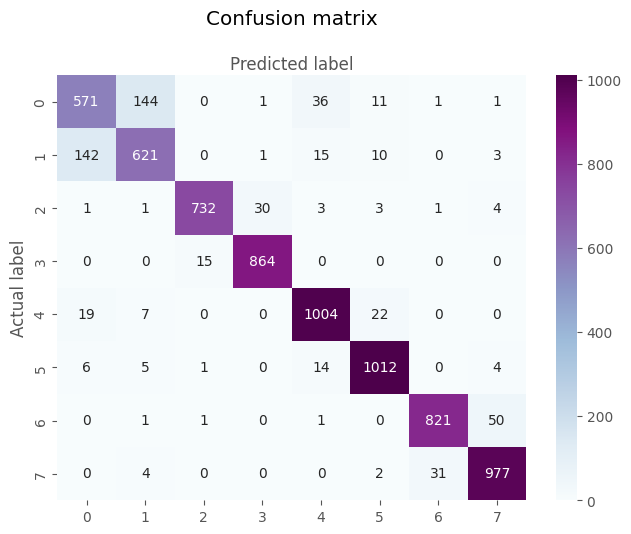

ROC AUC=0.9929


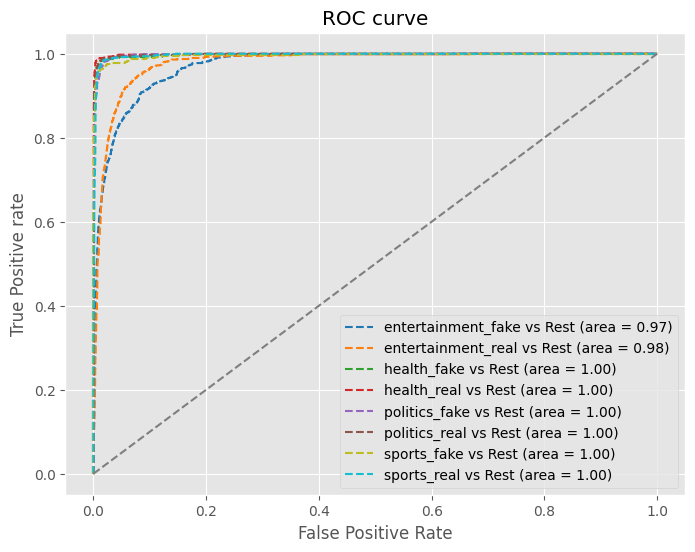

                    precision    recall  f1-score   support

entertainment_fake       0.77      0.75      0.76       765
entertainment_real       0.79      0.78      0.79       792
       health_fake       0.98      0.94      0.96       775
       health_real       0.96      0.98      0.97       879
     politics_fake       0.94      0.95      0.94      1052
     politics_real       0.95      0.97      0.96      1042
       sports_fake       0.96      0.94      0.95       874
       sports_real       0.94      0.96      0.95      1014

          accuracy                           0.92      7193
         macro avg       0.91      0.91      0.91      7193
      weighted avg       0.92      0.92      0.92      7193

Accuracy: 0.9178367857639371
f1_score: 0.9173710576952951


In [38]:
# вычисление и визуализация метрик качества
custom_evaluate(data_test['label'], torch.hstack(preds).detach().to('cpu'), torch.vstack(preds_proba).detach().to('cpu'))